project: B3_snSeq

author: LiChang Huang

title: scanpy_pipline

date: 2024/1/5

# prepare

## import library 

In [207]:
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## settings

In [208]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 150, dpi_save = 300, transparent = True)
sc.logging.print_versions()

%matplotlib inline

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         8.3.1
annoy                       NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
colorama                    0.4.6
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
entrypoints                 0.4
h5py                        3.7.0
igraph                      0.10.1
ipykernel                   6.15.2
jedi                        0.18.1
joblib                      1.3.2
kiwisolver                  1.4.4
leidenalg                   0.9.0
llvmlite                    0.39.1
matplotlib                  3.5.3
matplotlib_inline           0.1.6
mpl_toolkits                NA
natsort                     8.4.0
nbinom_ufunc                NA
numba                       0.56.3
numexpr                     2.8.3
numpy         

# load data 

In [209]:
os.chdir('/home/data/t140408/B3_snSeq/10X_data/')
os.getcwd()

'/home/data/t140408/B3_snSeq/10X_data'

In [210]:
adata_bfA = sc.read_10x_mtx(path = 'LC_917/', var_names = 'gene_symbols', cache = True)

... reading from cache file cache/LC_917-matrix.h5ad


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  + str(example_colliding_values)


In [211]:
adata_bfB = sc.read_10x_mtx(path = 'LC_971/', var_names = 'gene_symbols', cache = True)

... reading from cache file cache/LC_971-matrix.h5ad


In [212]:
adata_bfC = sc.read_10x_mtx(path = 'LC_1276/', var_names = 'gene_symbols', cache = True)

... reading from cache file cache/LC_1276-matrix.h5ad


In [213]:
adata_AFA = sc.read_10x_mtx(path = 'LC_1146/', var_names = 'gene_symbols', cache = True)

... reading from cache file cache/LC_1146-matrix.h5ad


In [214]:
adata_AFB = sc.read_10x_mtx(path = 'LC_1149/', var_names = 'gene_symbols', cache = True)

... reading from cache file cache/LC_1149-matrix.h5ad


In [215]:
adata_AFC = sc.read_10x_mtx(path = 'LC_H0159/', var_names = 'gene_symbols', cache = True)

... reading from cache file cache/LC_H0159-matrix.h5ad


In [231]:
adata_list = [adata_bfA.copy(), adata_bfB.copy(), adata_bfC.copy(), adata_AFA.copy(), adata_AFB.copy(), adata_AFC.copy()] # 深拷贝

In [232]:
batch_names = ('bf_A', 'bf_B', 'bf_C', 'AF_A', 'AF_B', 'AF_C')
for i in range(len(adata_list)):
    adata_list[i].obs['batch'] = batch_names[i]

# QC 

In [233]:
for i in range(len(adata_list)):
    sc.pp.filter_genes(adata_list[i], min_cells = 20)
    sc.pp.filter_cells(adata_list[i], min_genes = 20)

filtered out 36182 genes that are detected in less than 20 cells
filtered out 40535 genes that are detected in less than 20 cells
filtered out 38461 genes that are detected in less than 20 cells
filtered out 33175 genes that are detected in less than 20 cells
filtered out 36802 genes that are detected in less than 20 cells
filtered out 32052 genes that are detected in less than 20 cells


In [234]:
for i in range(len(adata_list)): 
    adata_list[i].var['mt'] = adata_list[i].var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata_list[i], qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

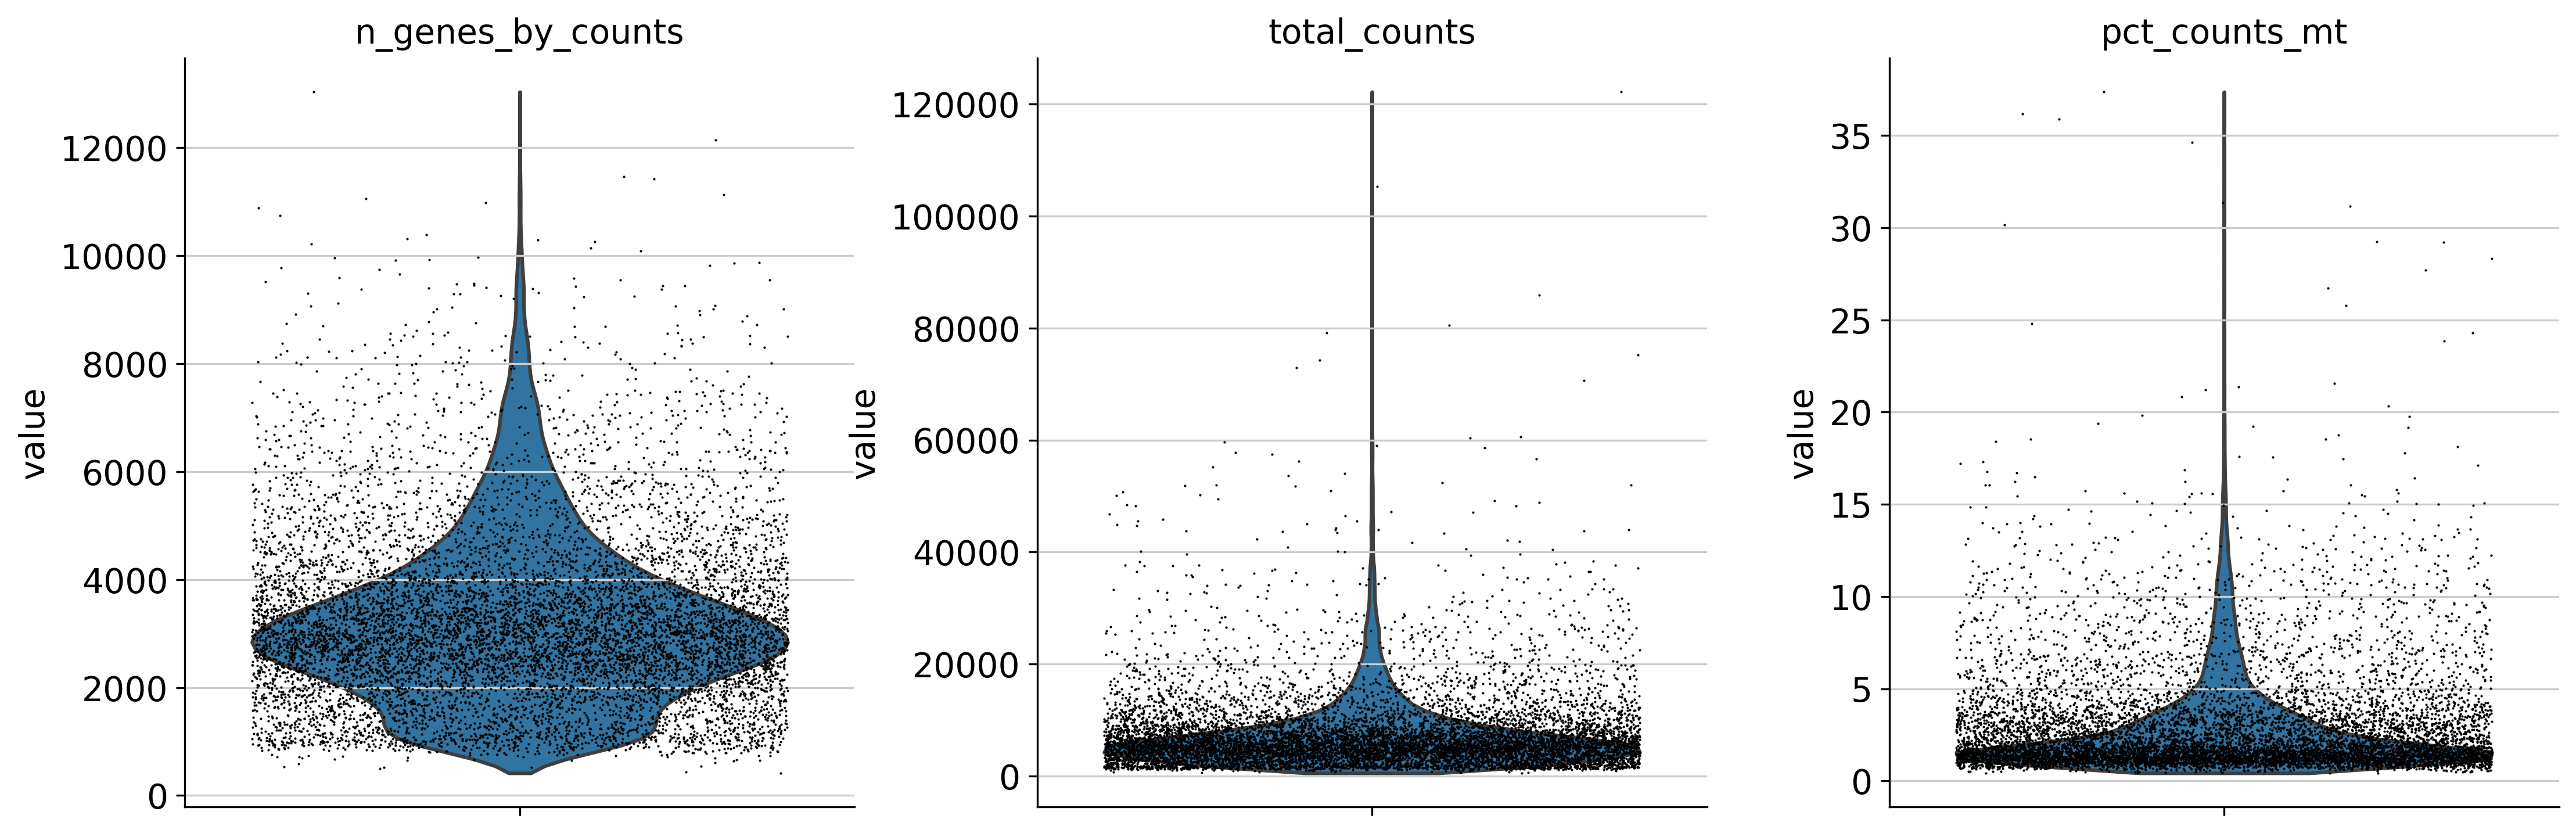

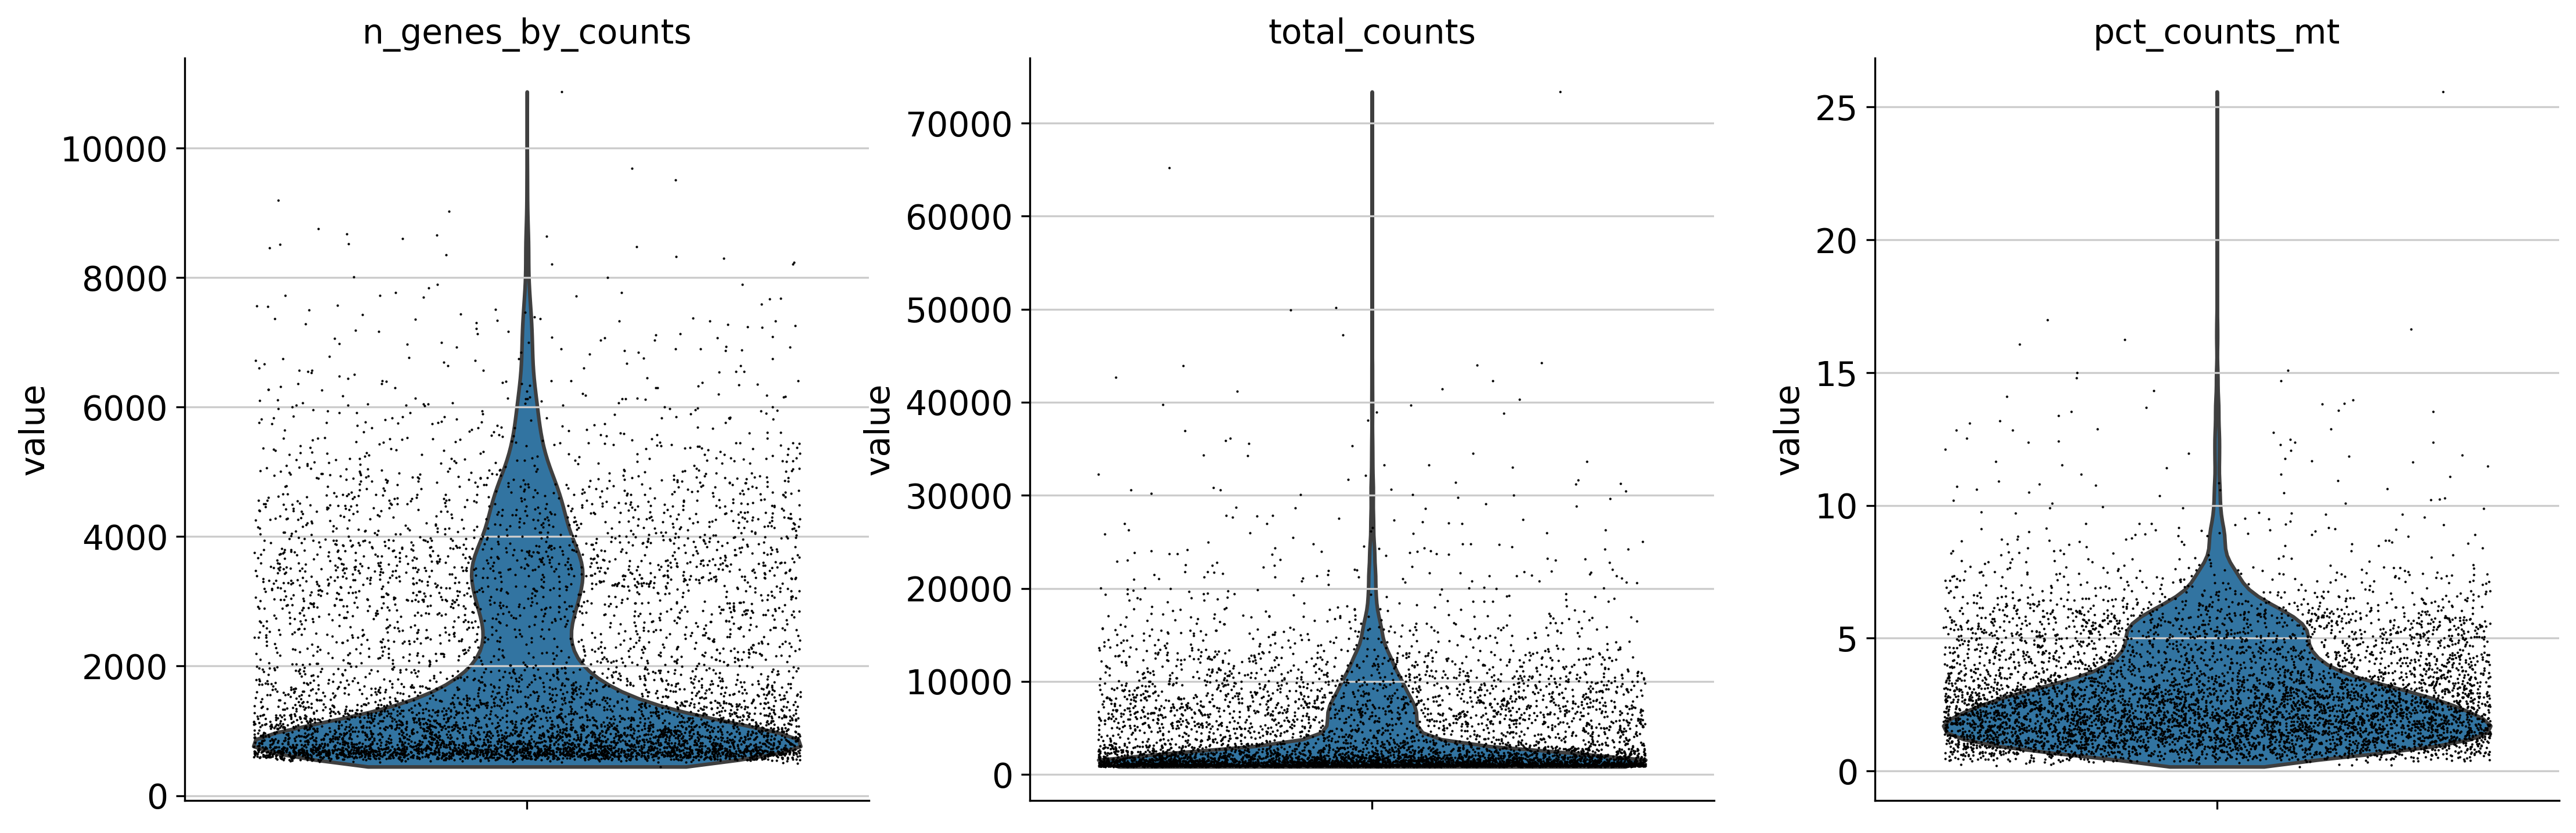

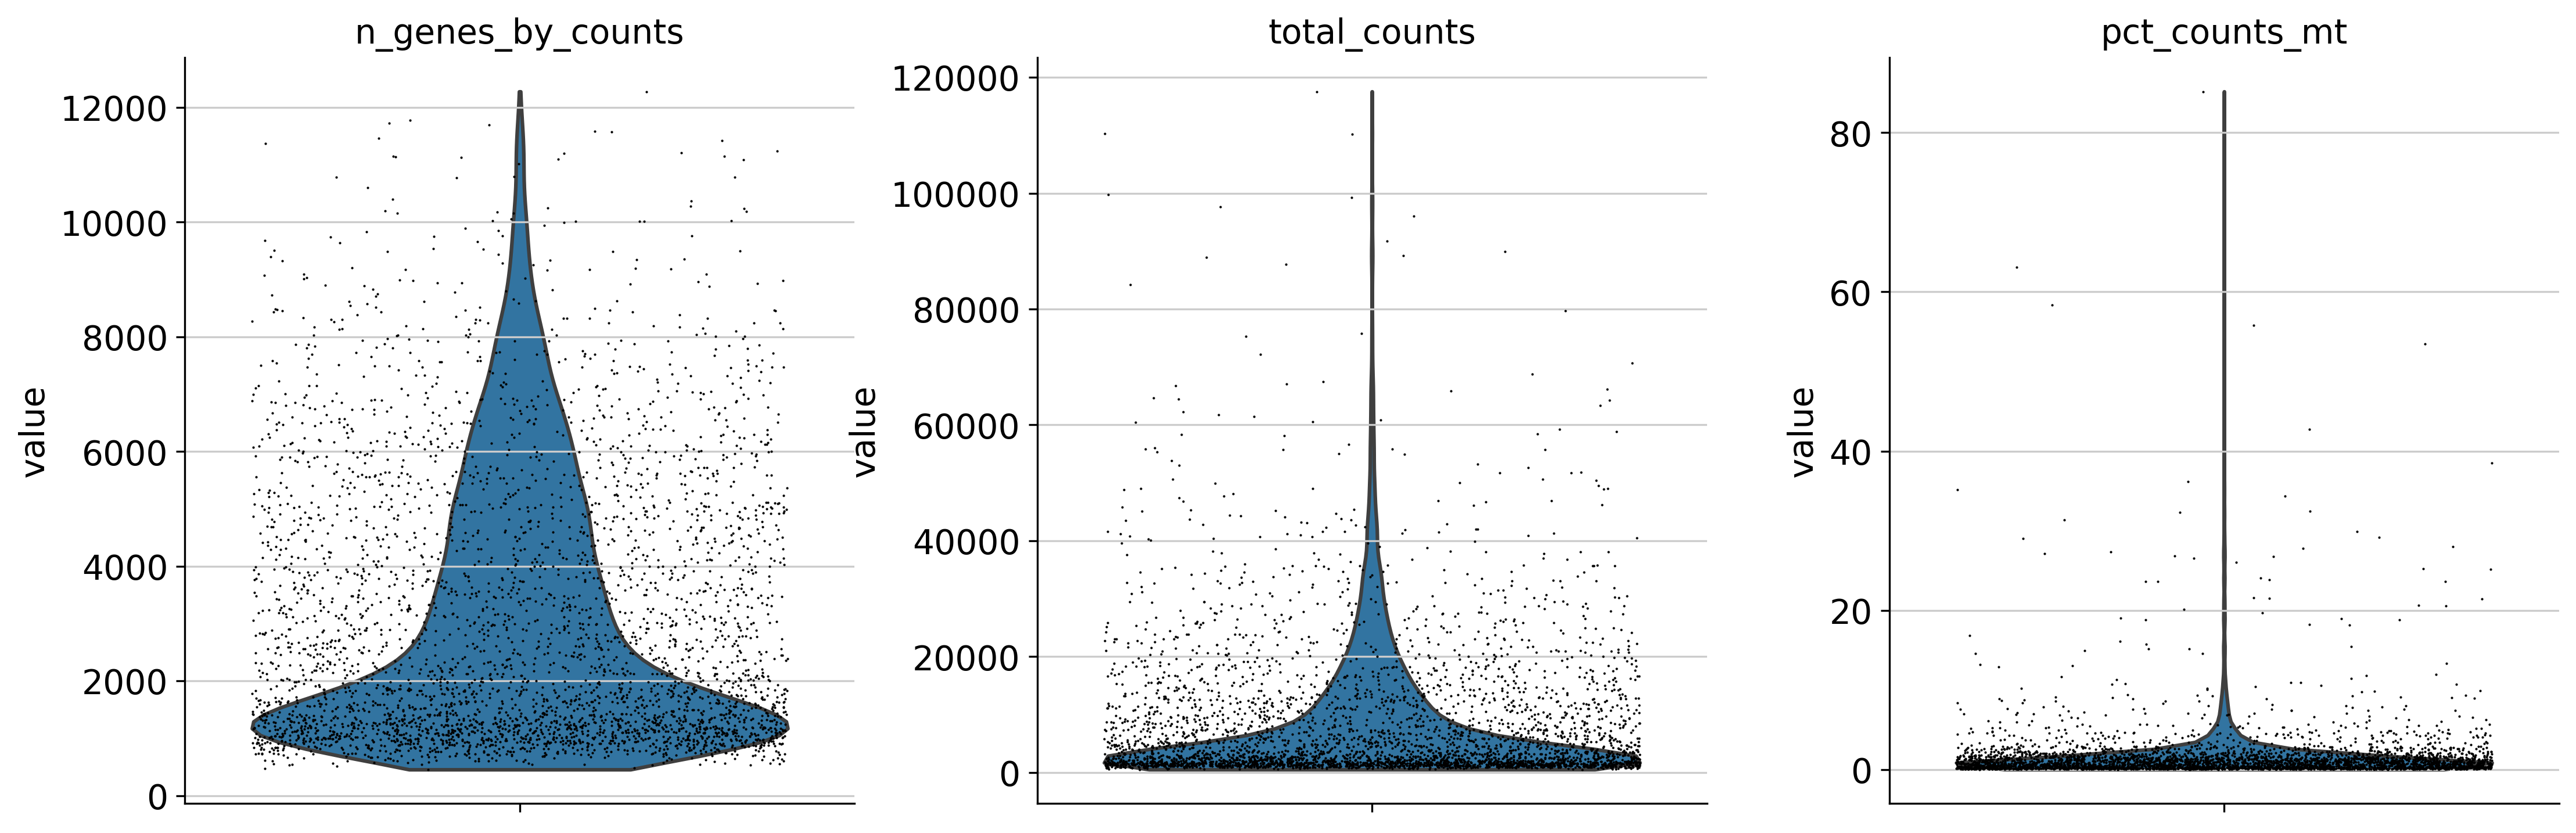

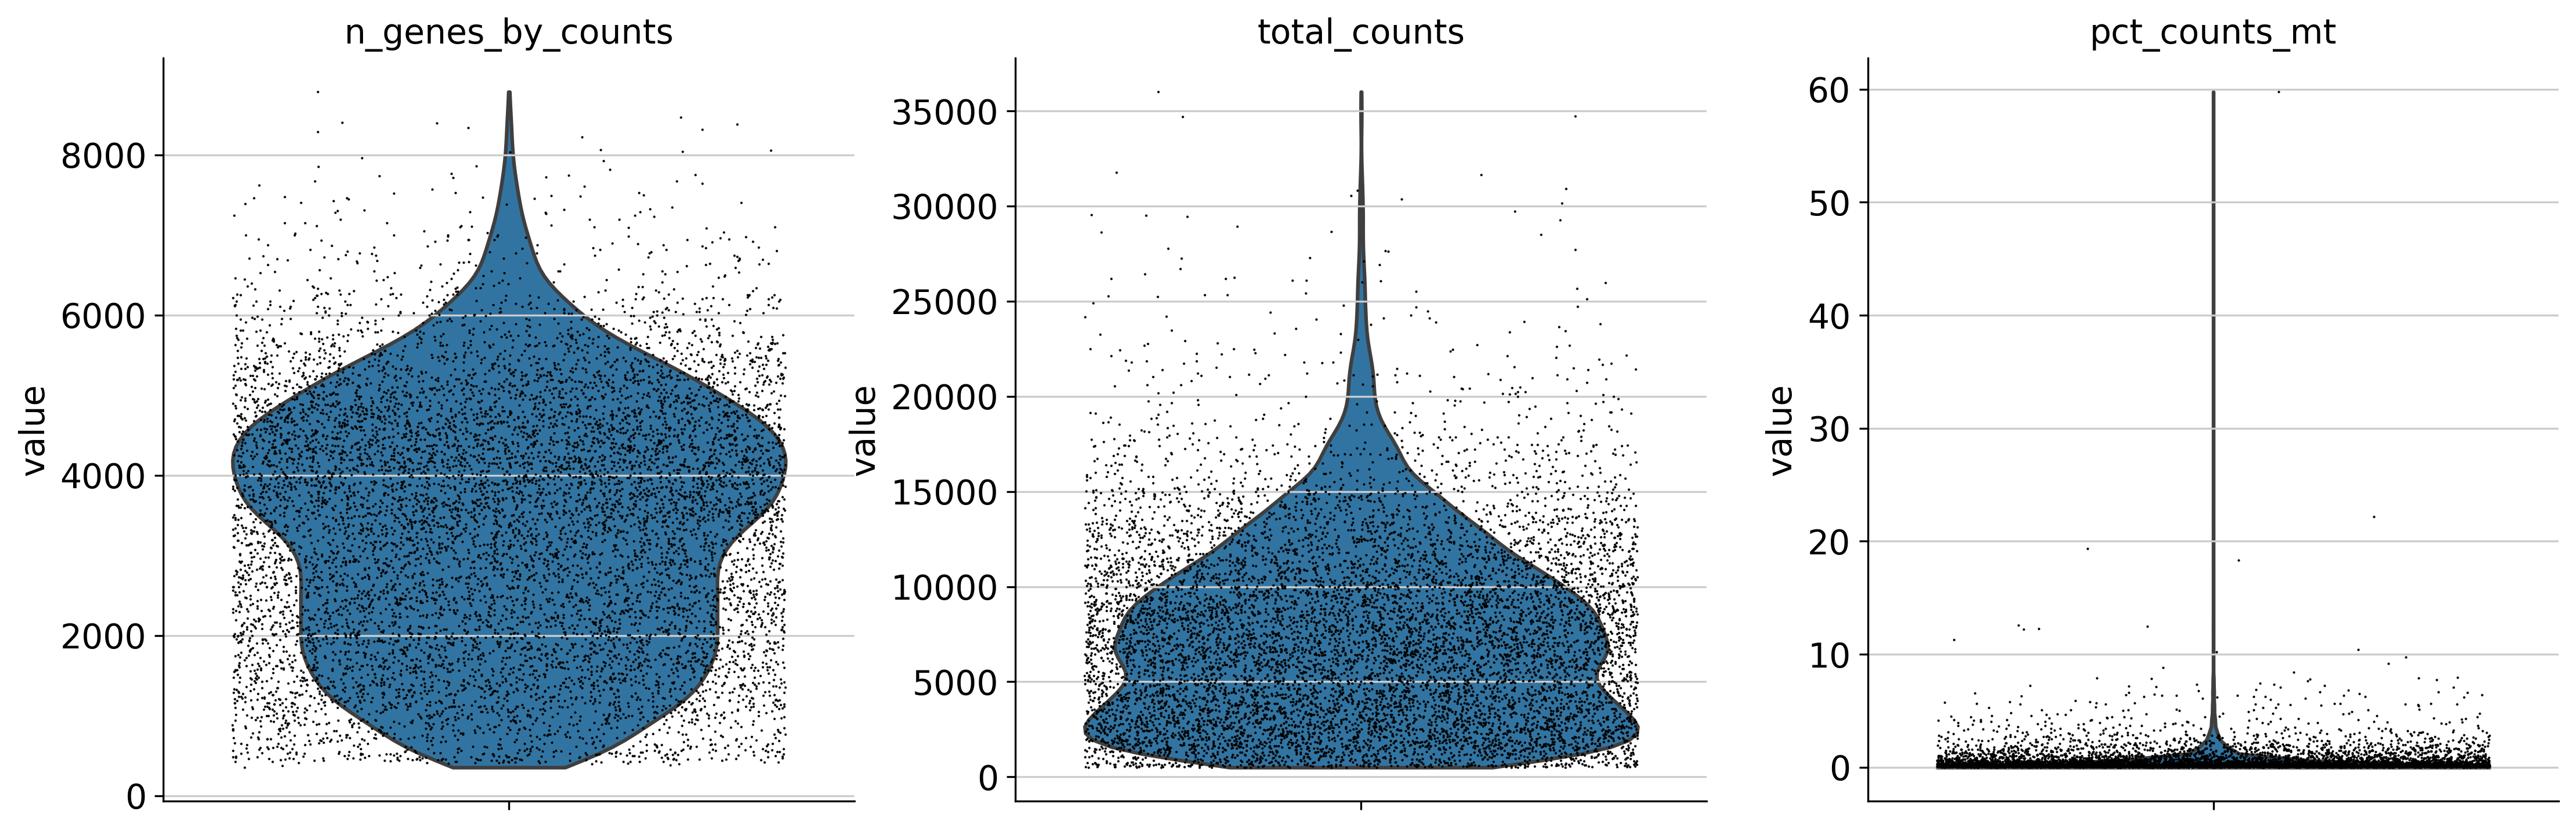

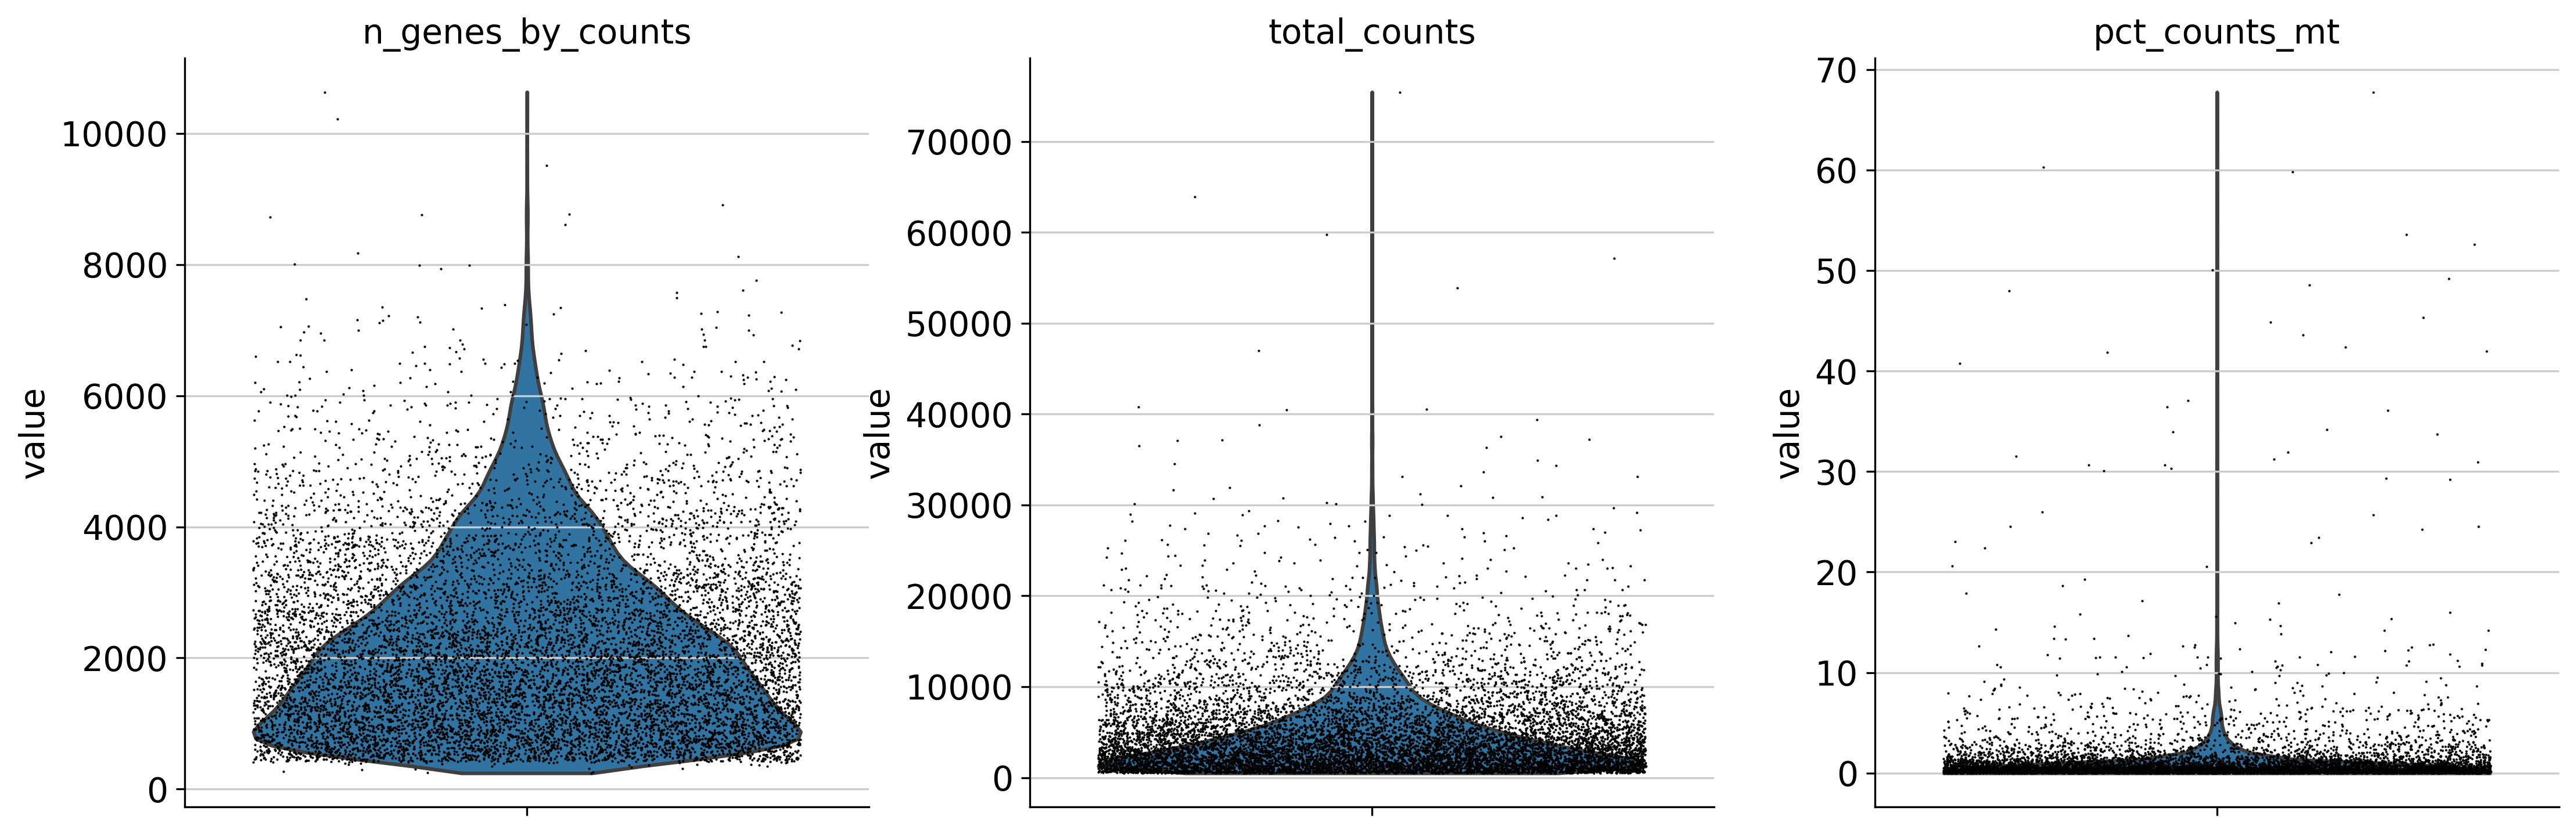

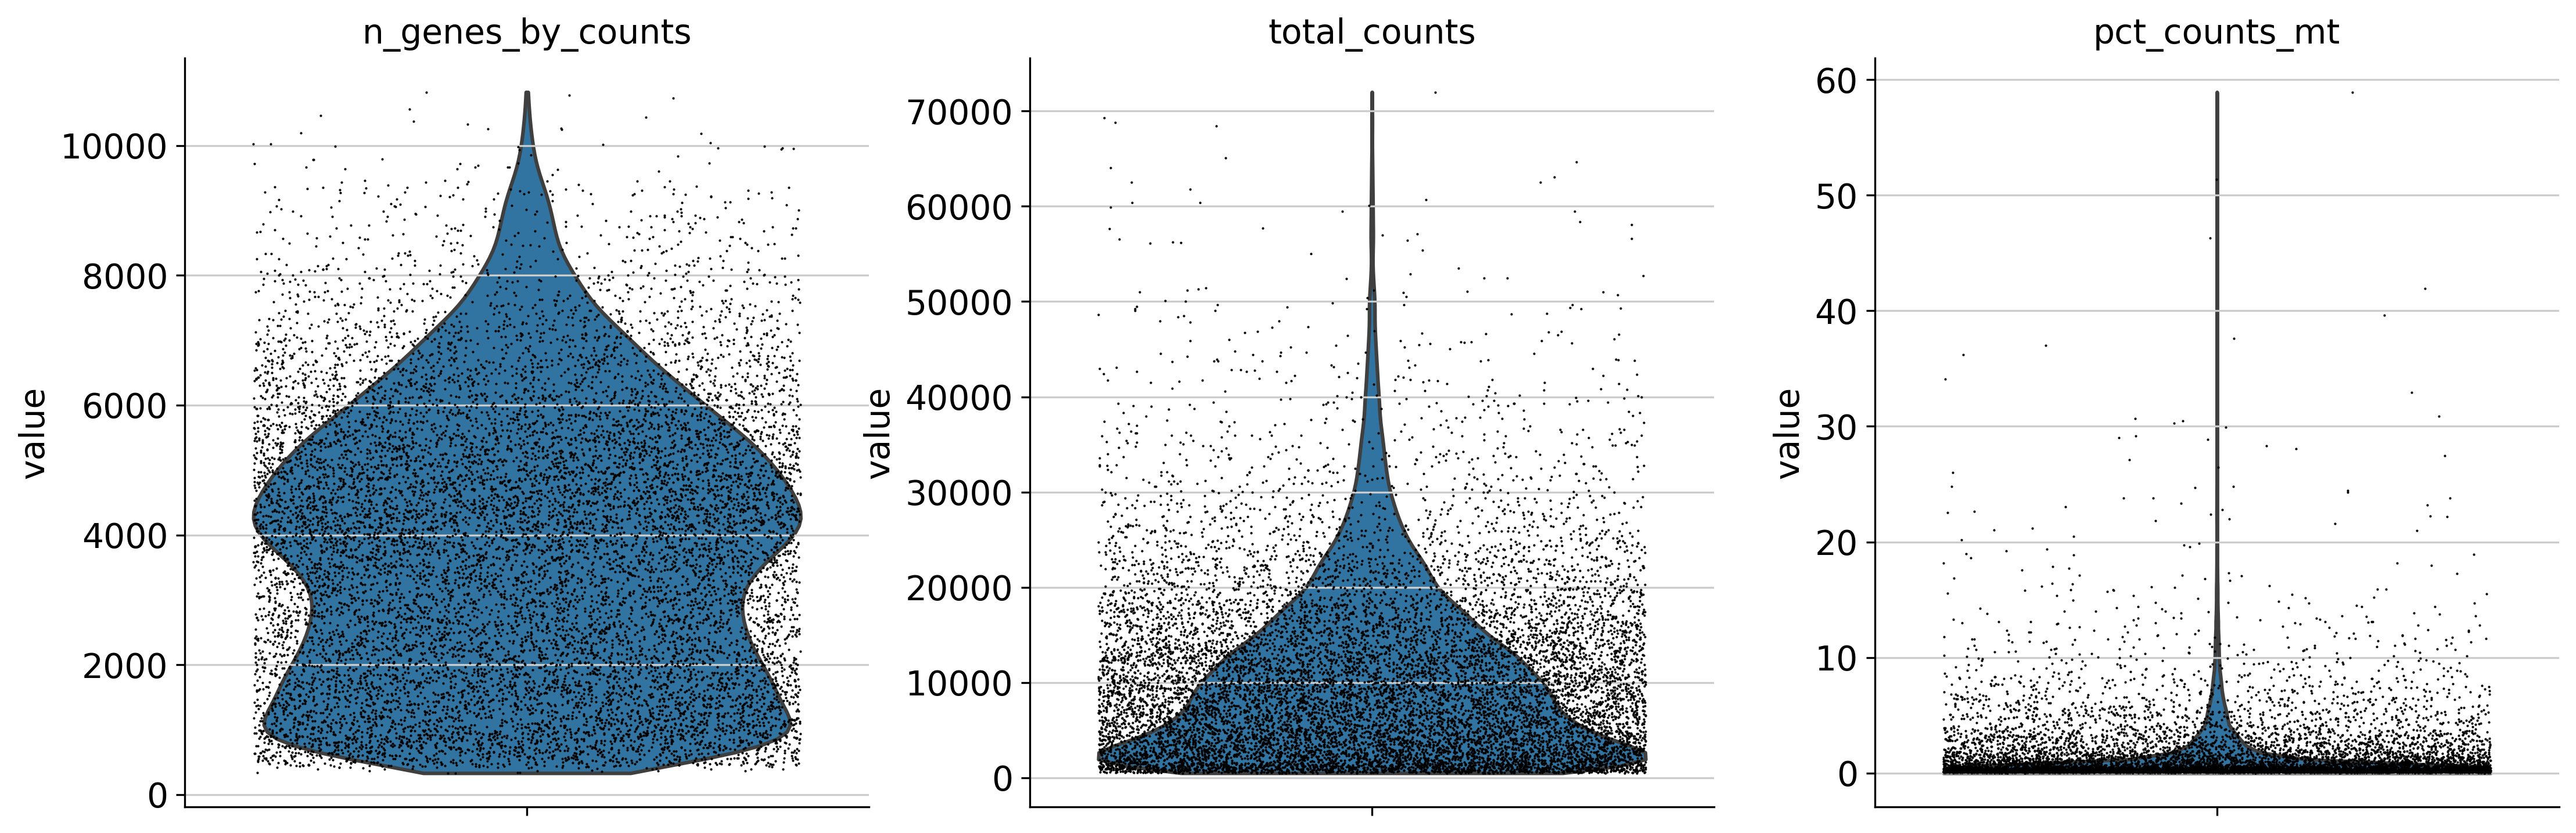

In [220]:
for i in range(len(adata_list)): 
    sc.pl.violin(adata_list[i], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter = 0.4, multi_panel = True)

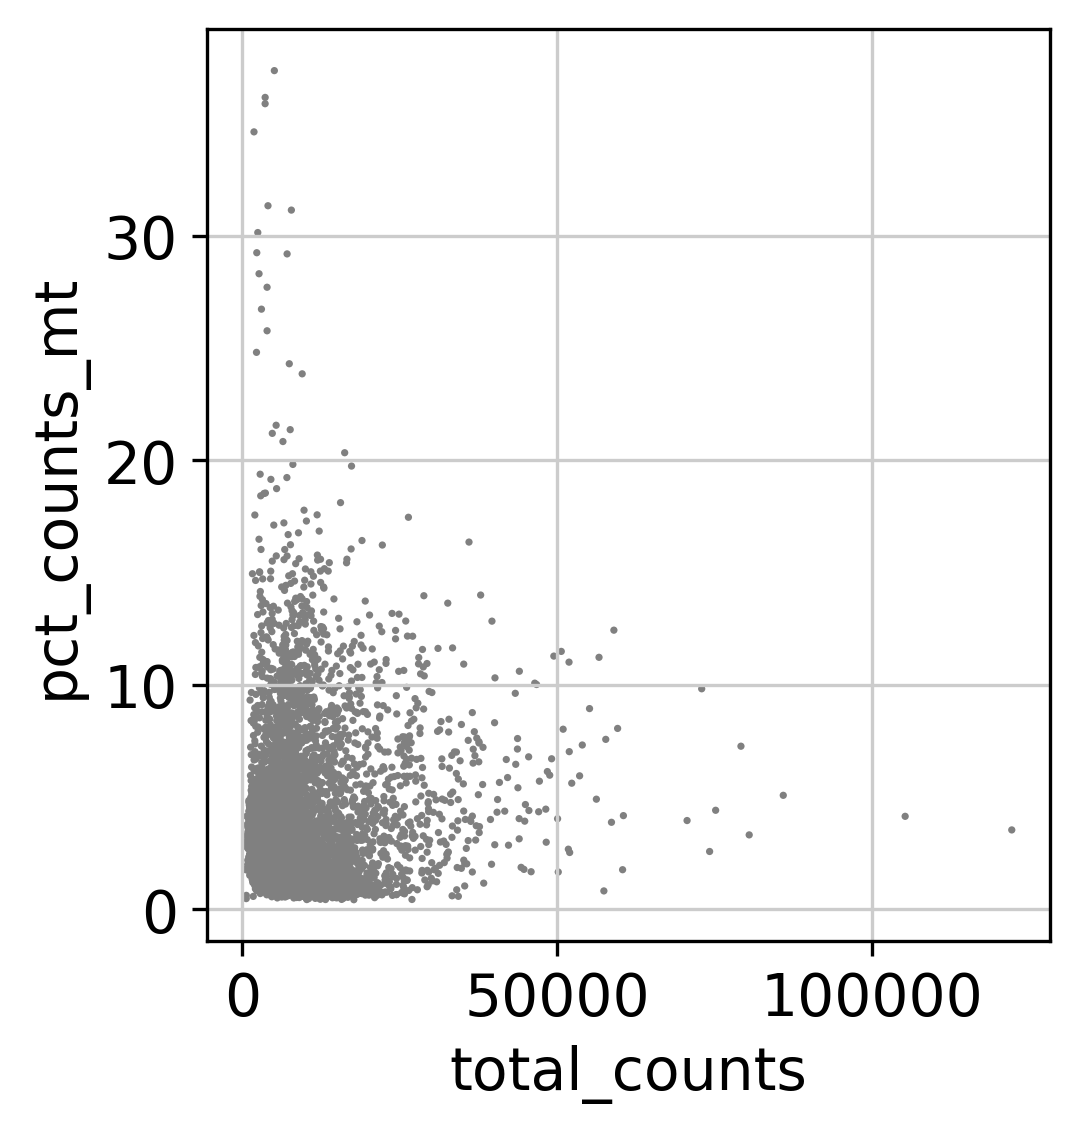

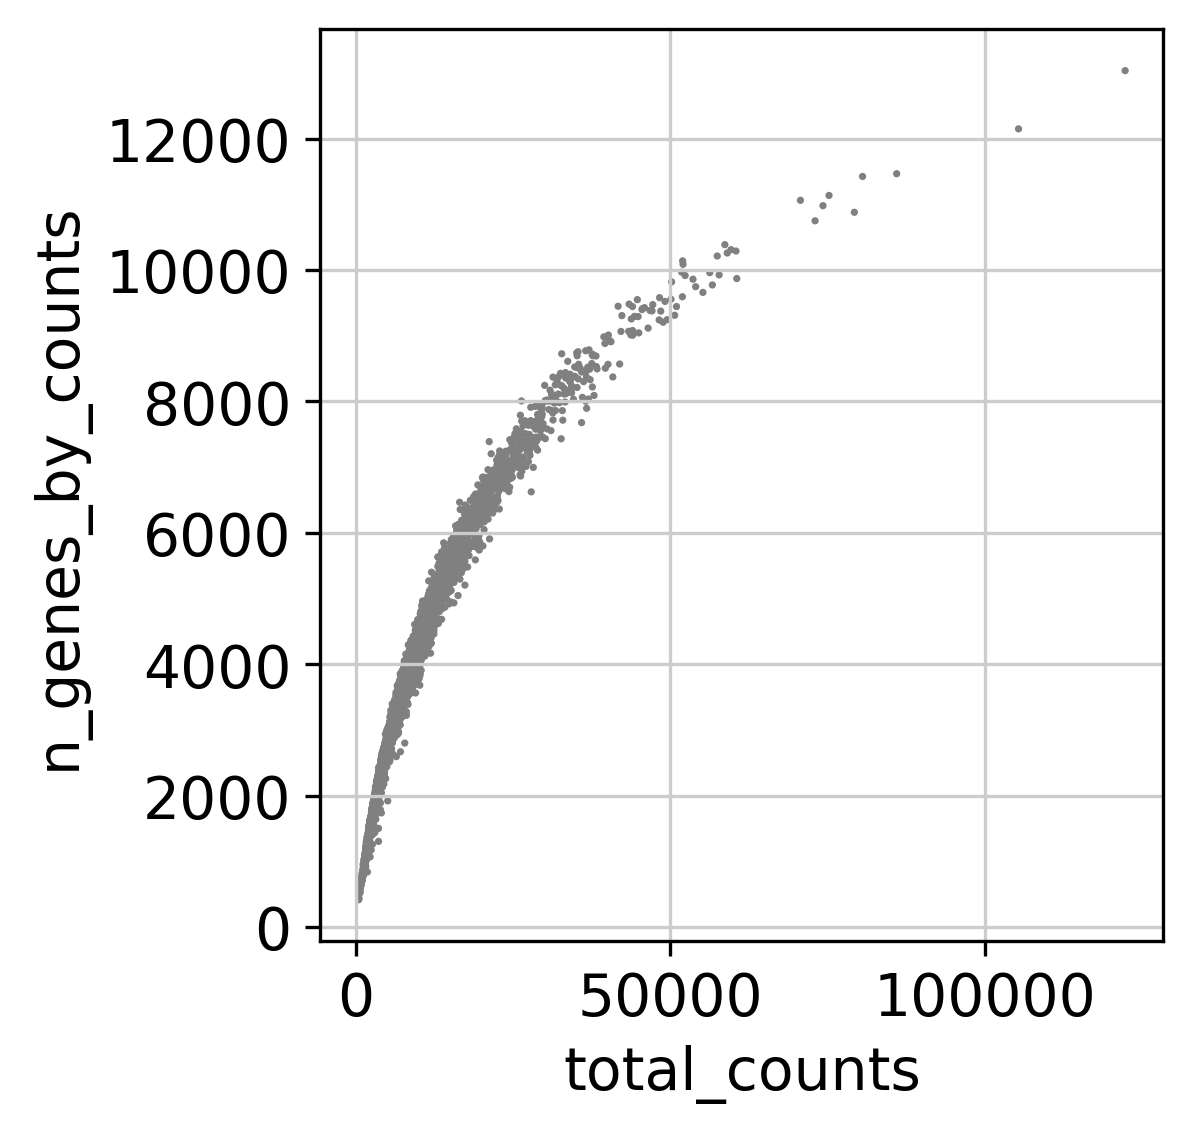

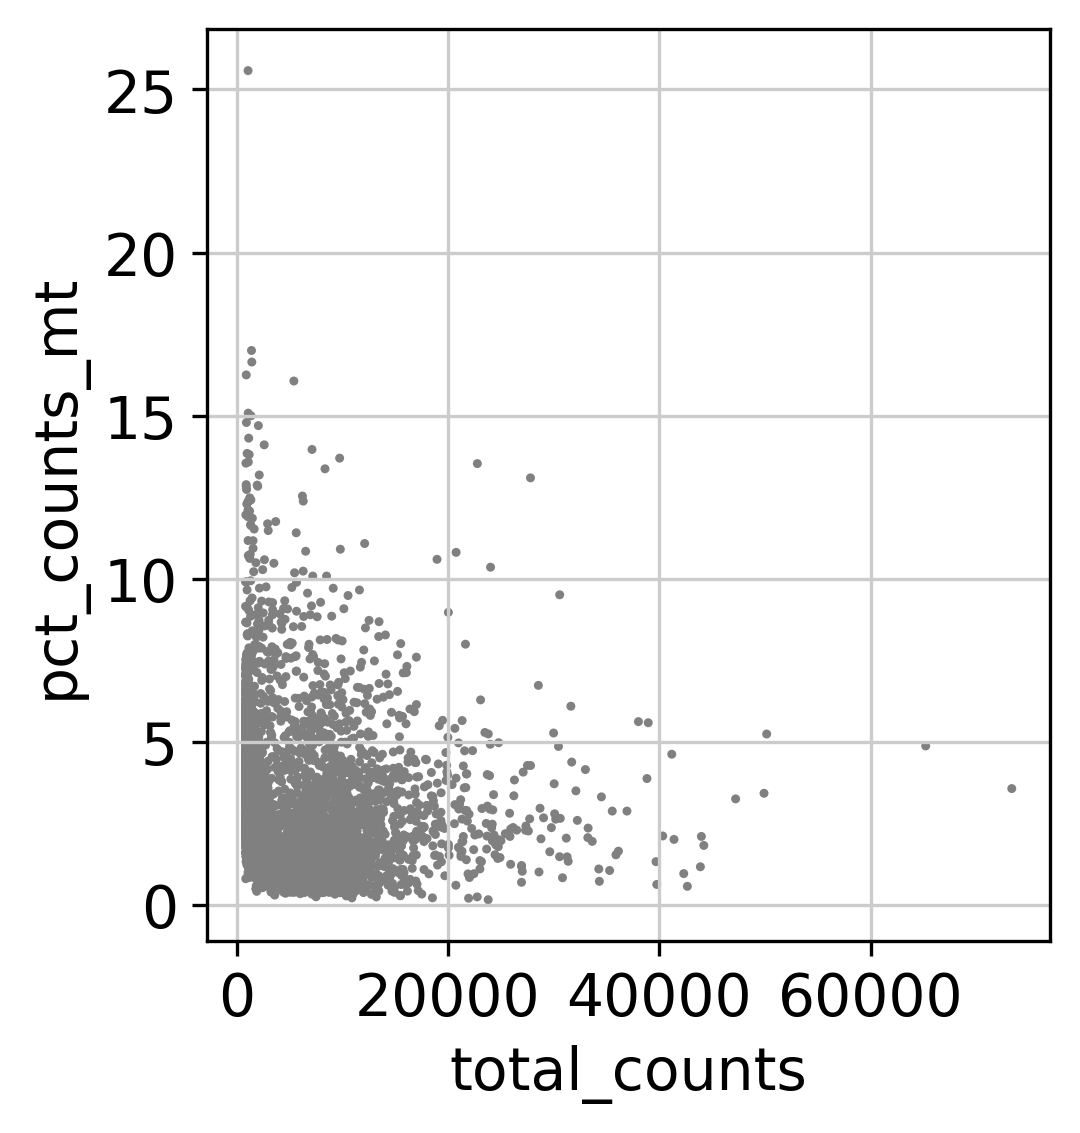

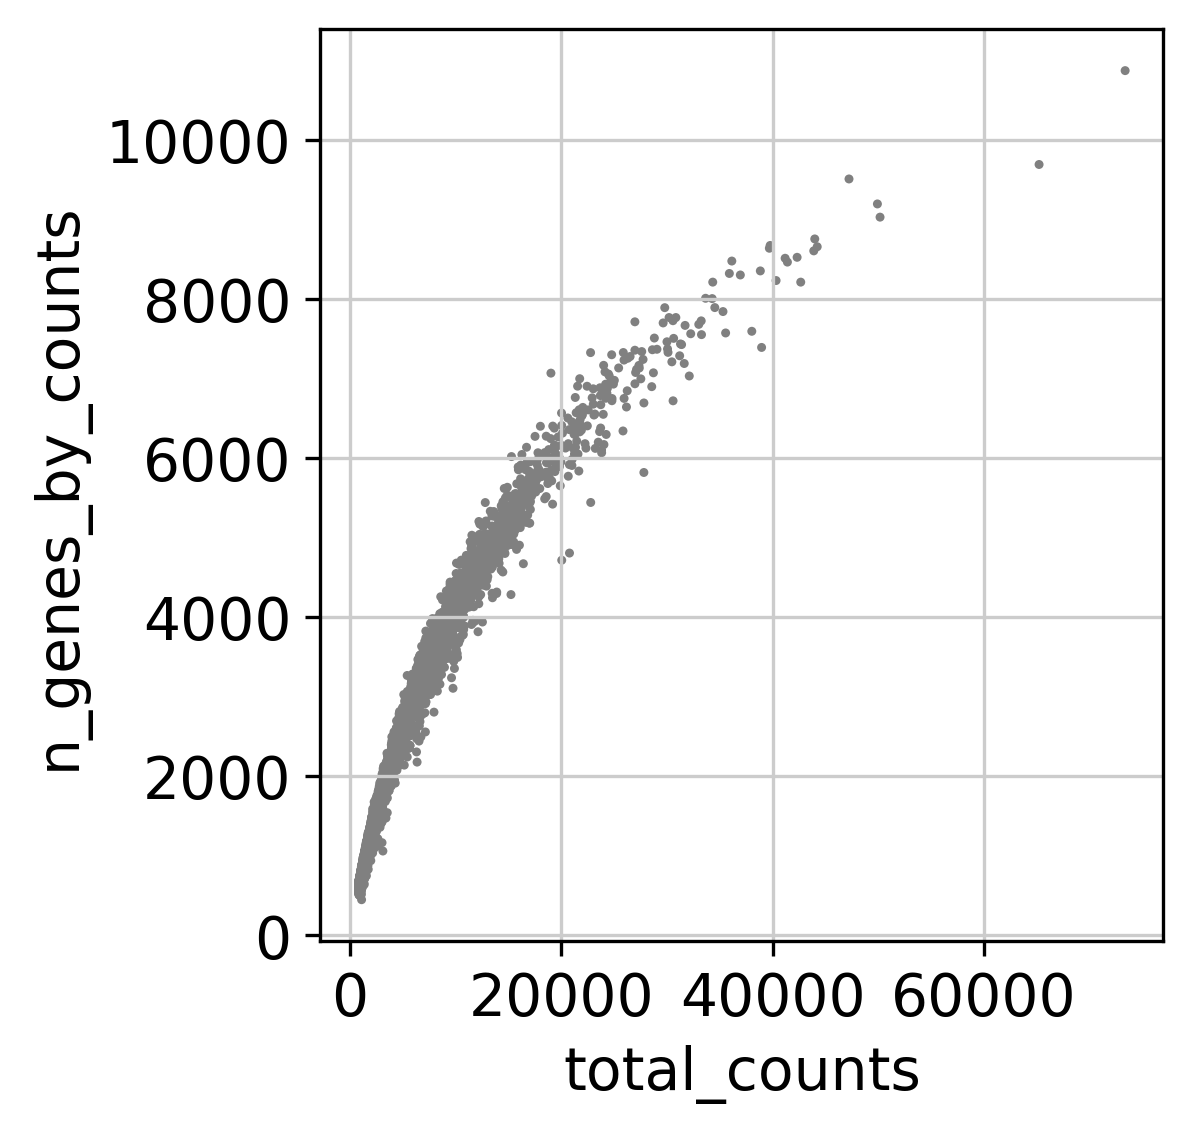

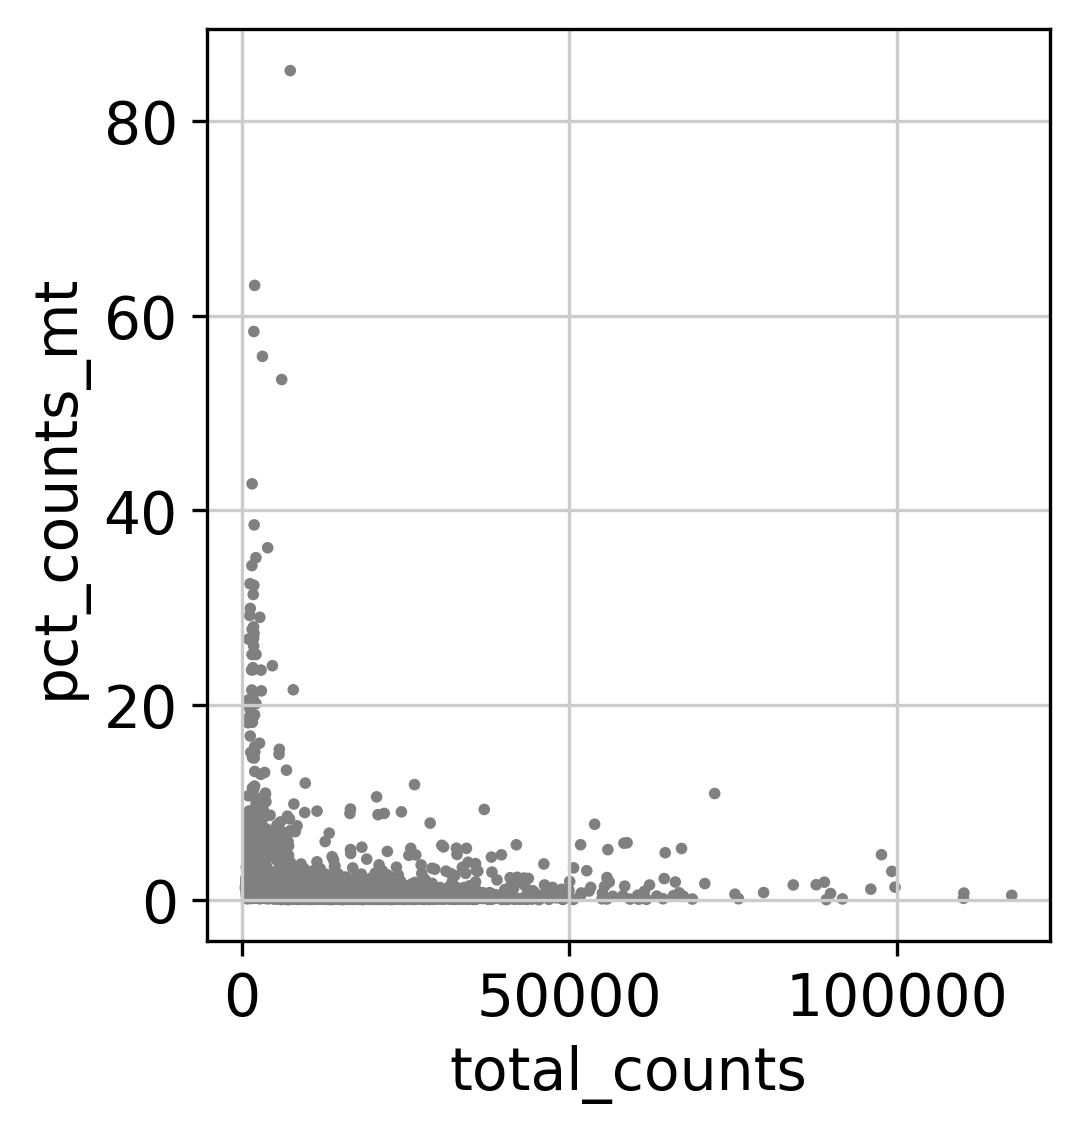

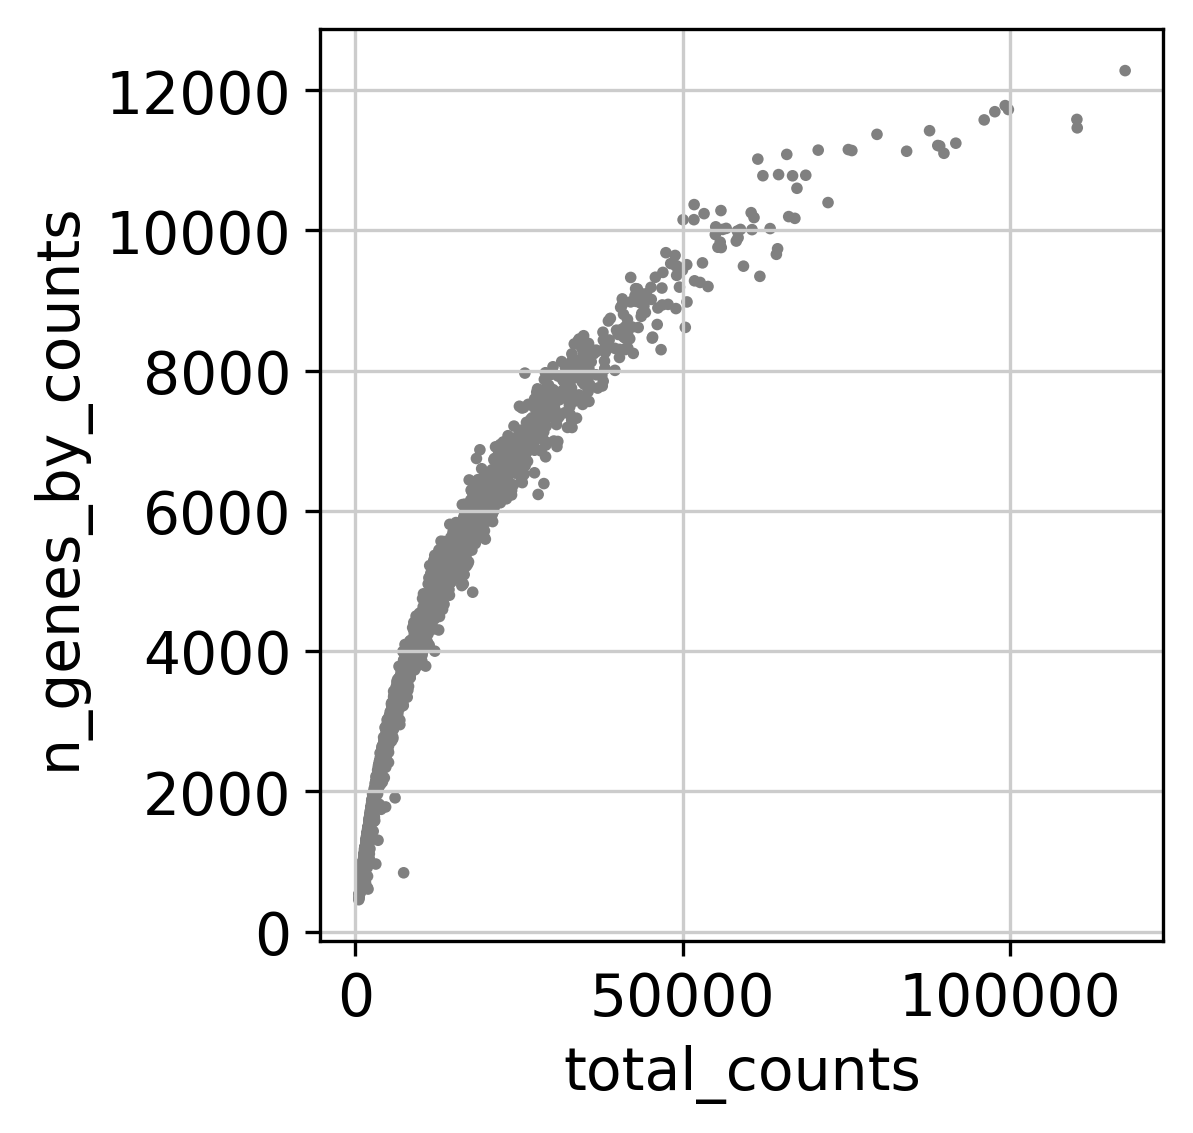

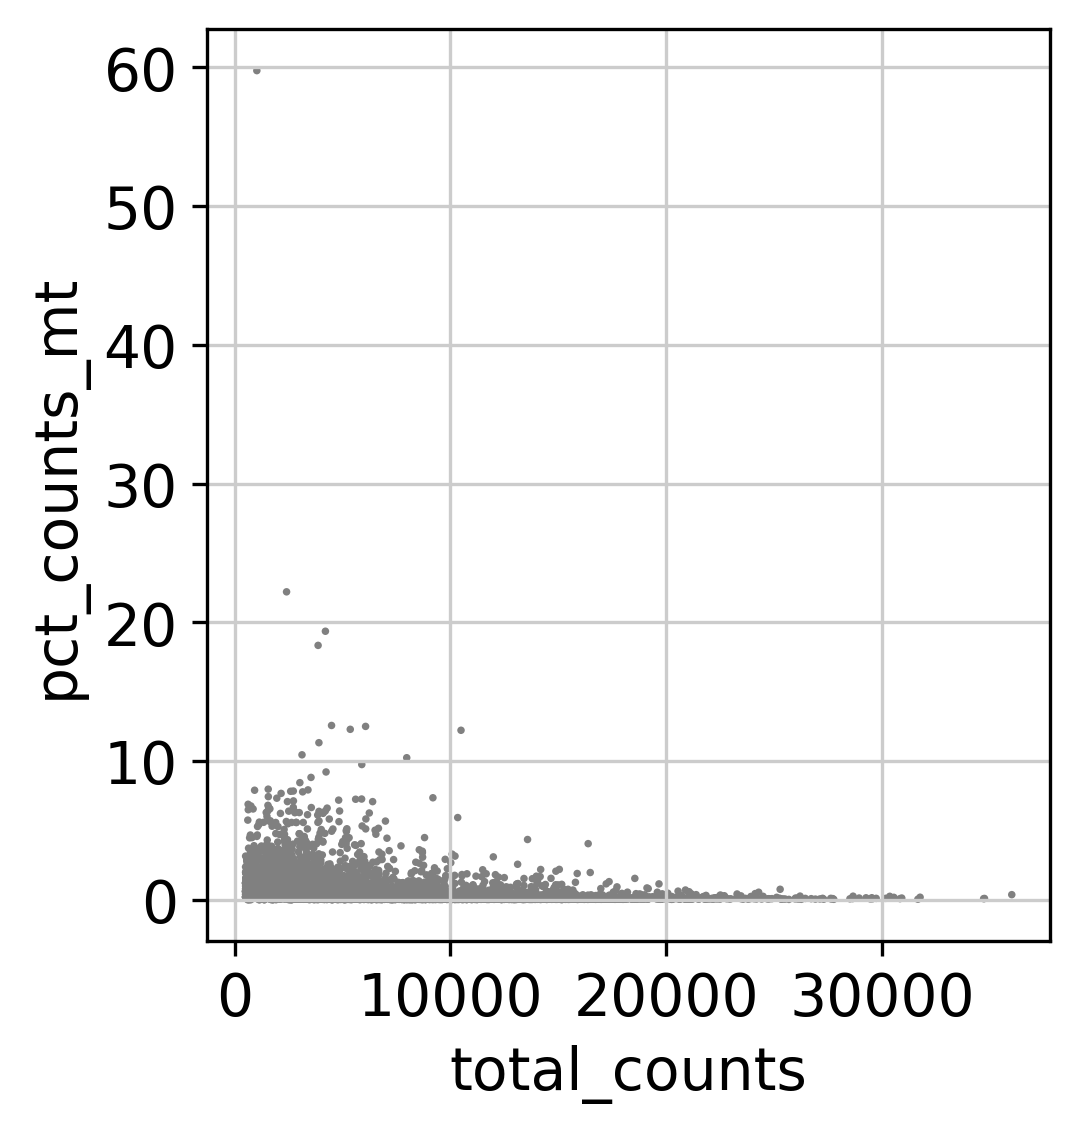

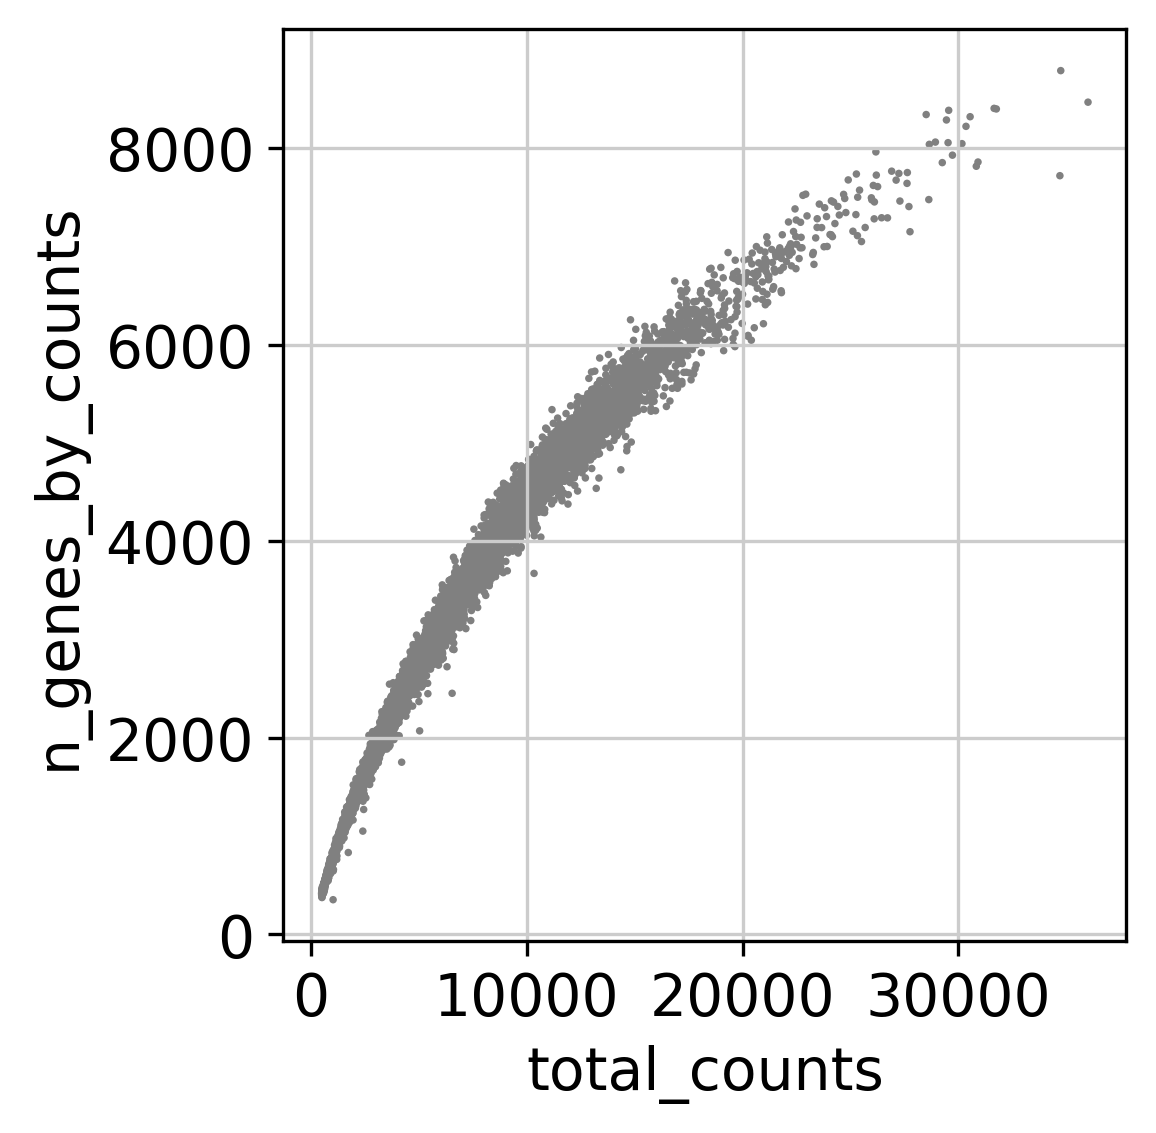

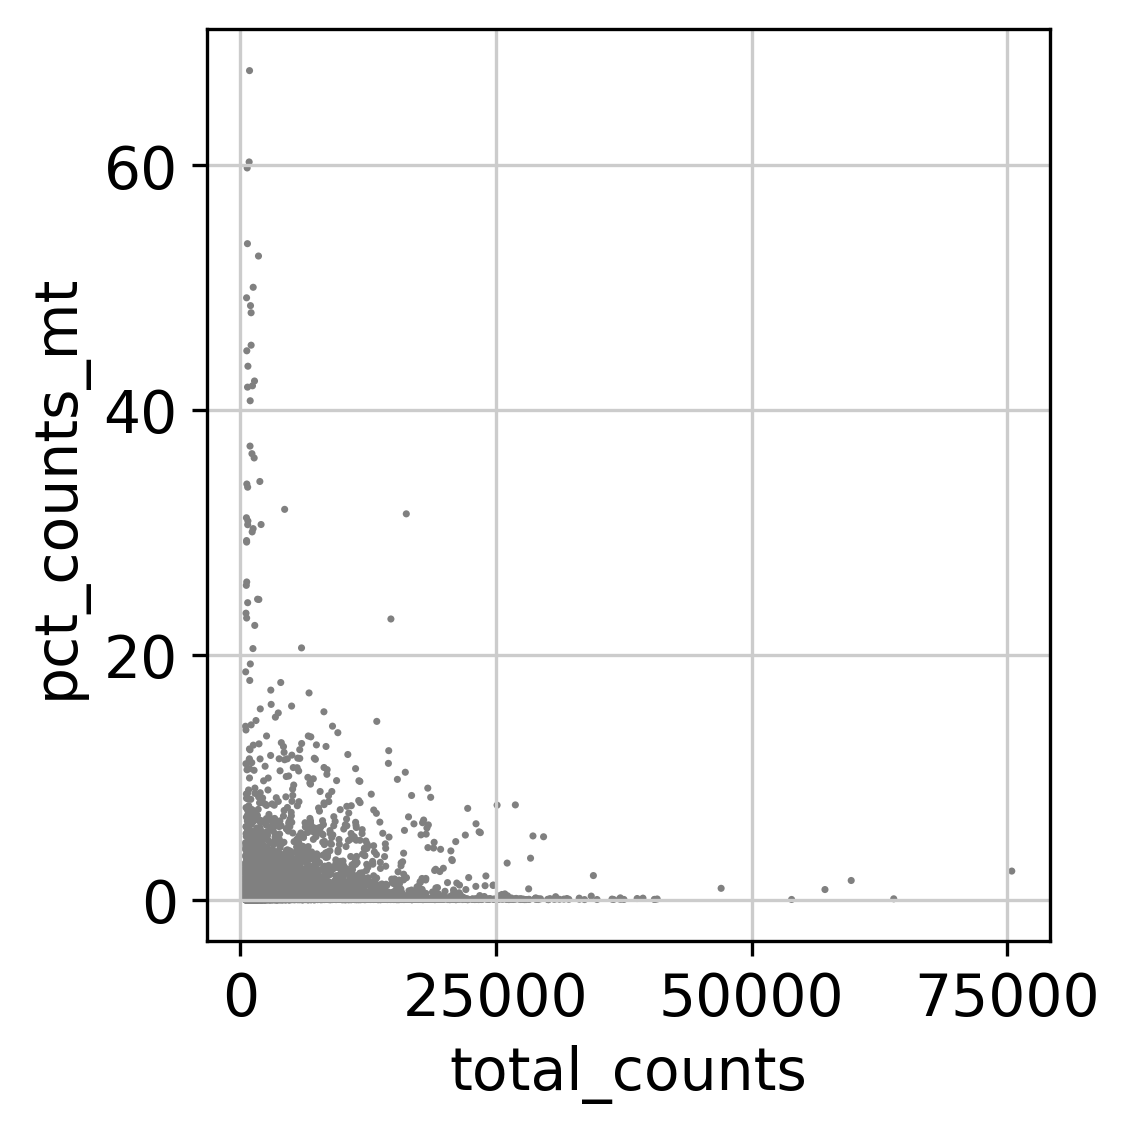

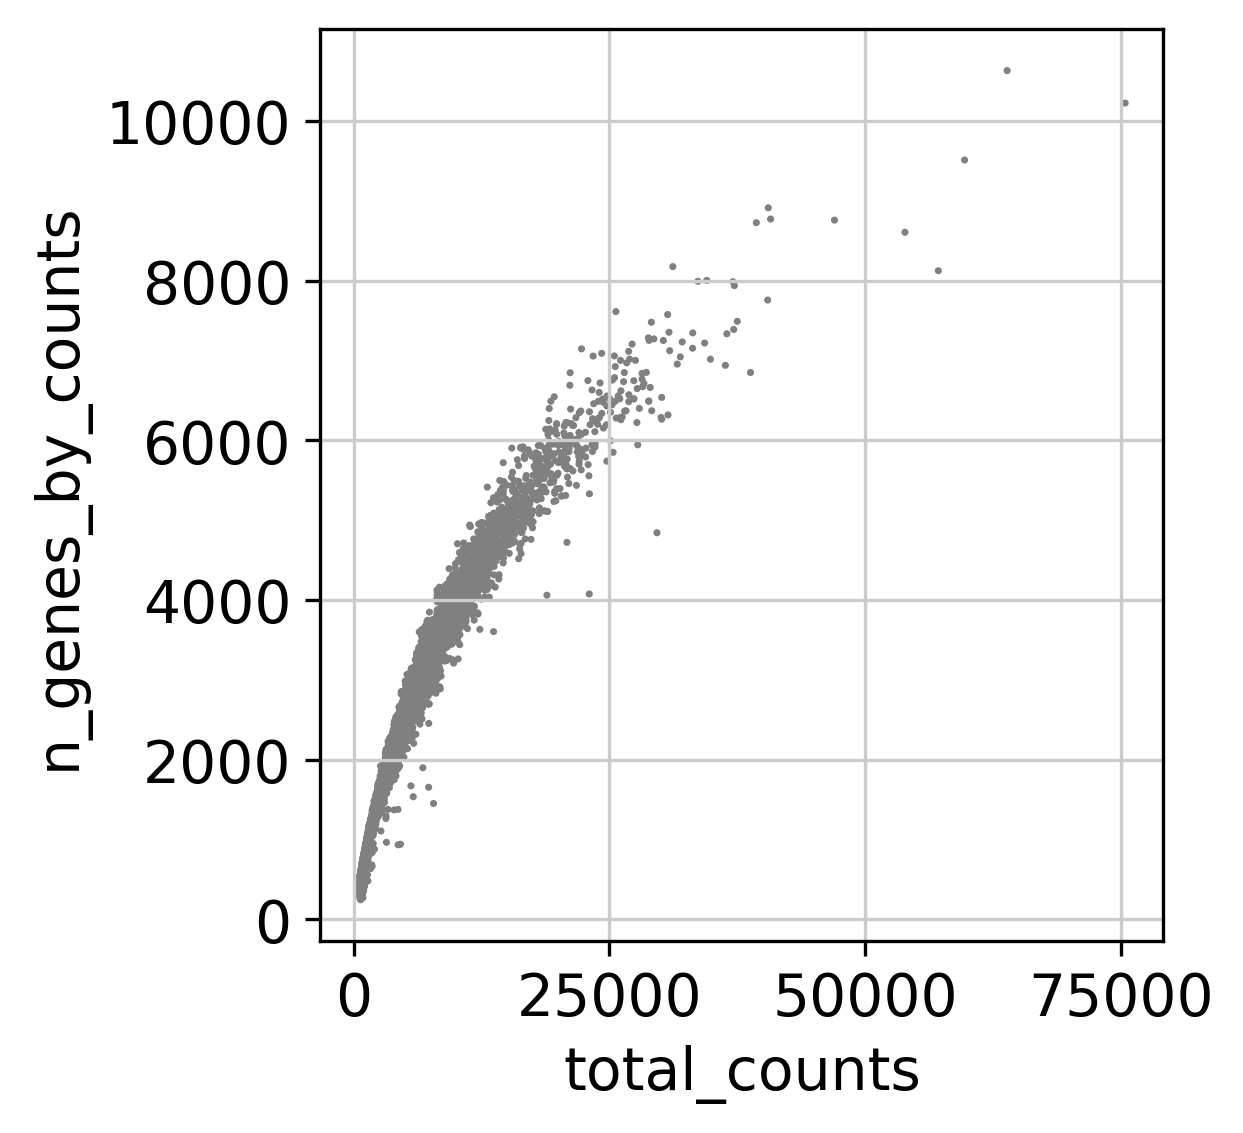

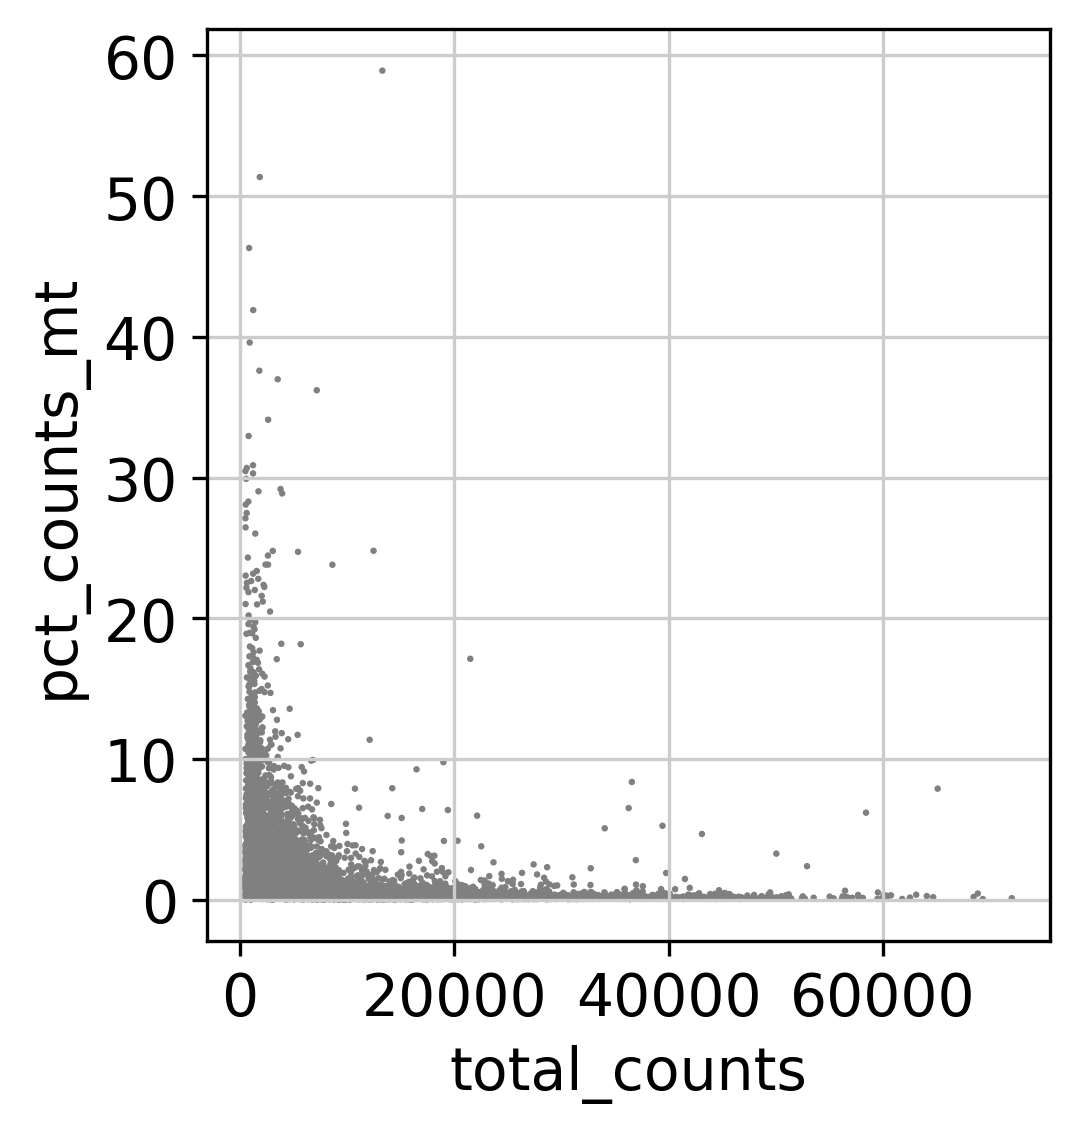

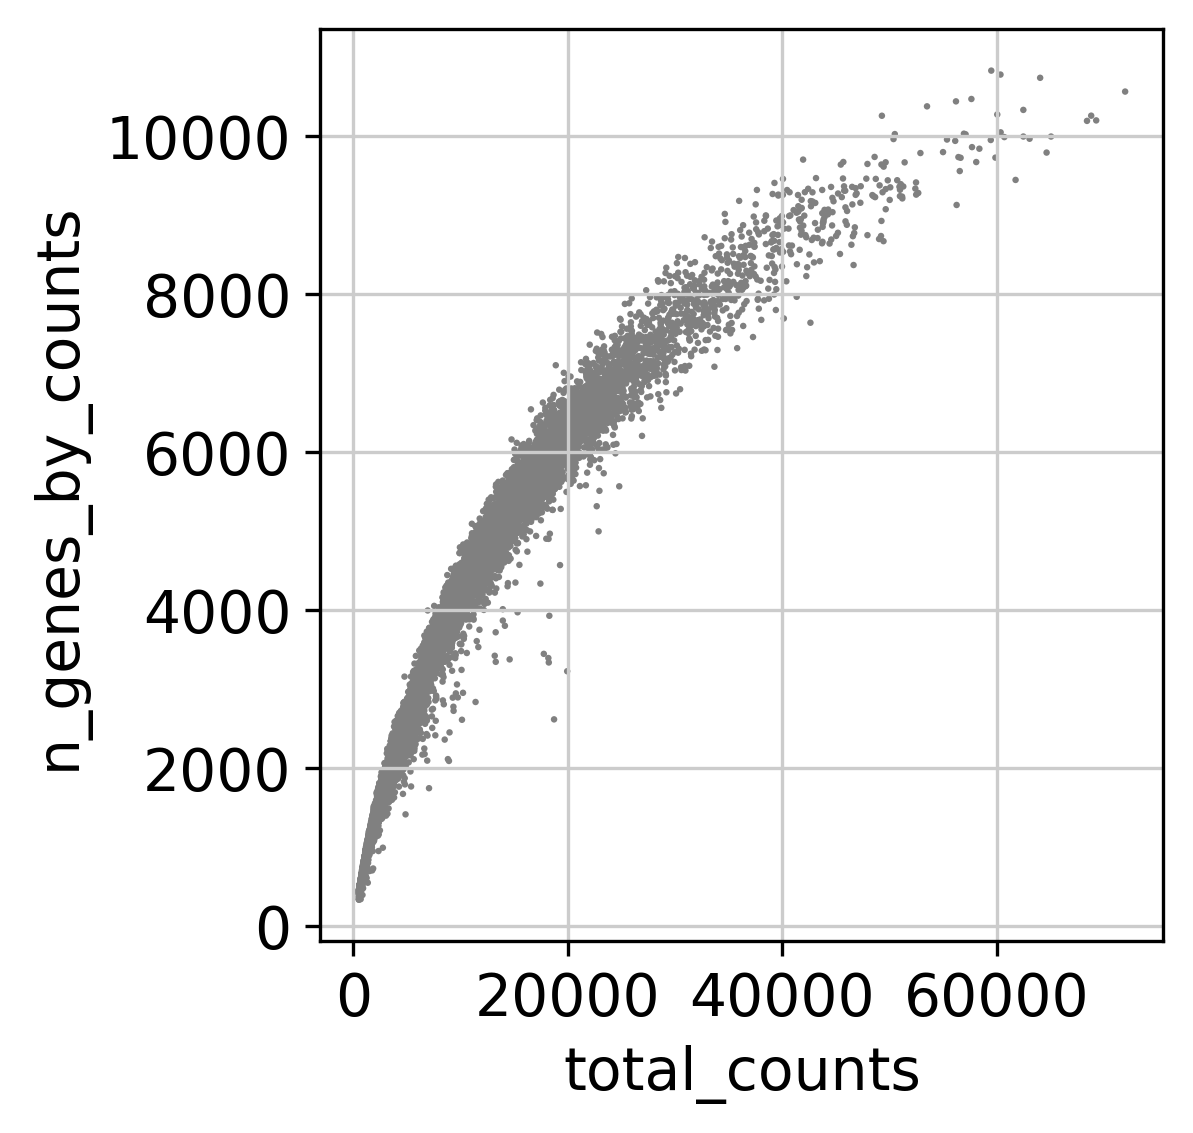

In [221]:
for i in range(len(adata_list)):
    sc.pl.scatter(adata_list[i], x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata_list[i], x='total_counts', y='n_genes_by_counts')

In [235]:
for i in range(len(adata_list)):
    adata_list[i] = adata_list[i][(300 < adata_list[i].obs.n_genes_by_counts) & (adata_list[i].obs.n_genes_by_counts < 7000) & 
                                  (adata_list[i].obs.pct_counts_mt < 10) & 
                                  (200 < adata_list[i].obs.total_counts) &  (adata_list[i].obs.total_counts< 20000), :]

## filter Doublet with  DoubletFinder from R

``` R
setwd('~/B3_snSeq/R_project/QC/results/')
metadata.with.DFresults <- read_rds('./metadata-with-DFresults.RDS')

for (i in 1:length(metadata.with.DFresults)) {
  rownames(metadata.with.DFresults[[i]]) <- str_split(rownames(metadata.with.DFresults[[i]]), 
                                                      pattern = '_', simplify = T)[, 2]
  metadata.with.DFresults[[i]] <- rownames_to_column(metadata.with.DFresults[[i]], var = 'barcode')
  data_name = metadata.with.DFresults[[i]][, 'orig.ident'] |> unique()
  path = str_c('metadataWithDFresultsCsv/DFresults_', data_name, '.csv')
  write_csv(metadata.with.DFresults[[i]][, c(1,3)], file = path)
}
```

In [236]:
adata_list_DFfiltered = [adata_list[i].copy() for i in range(len(adata_list))]  # 深拷贝

In [237]:
os.chdir('/home/data/t140408/B3_snSeq/R_project/QC/results/metadataWithDFresultsCsv')
DFresults_path = ['./DFresults_bf-A.csv', './DFresults_bf-B.csv','./DFresults_bf-C.csv','./DFresults_AF-A.csv', 
                  './DFresults_AF-B.csv', './DFresults_AF-C.csv']
DFresults = [pd.read_csv(filepath_or_buffer=csv) for csv in DFresults_path]

In [238]:
for i in range(len(adata_list_DFfiltered)):
    adata_list_DFfiltered[i].obs = adata_list_DFfiltered[i].obs.sort_index()
    DFresults[i] = DFresults[i].sort_values('barcode')
    # series本身的index与dataframe的冲突，所以需要取值后赋值
    adata_list_DFfiltered[i].obs[DFresults[i].iloc[:, 1].name] = DFresults[i].iloc[:, 1].astype(dtype='category').values

In [241]:
for i in range(len(adata_list_DFfiltered)):
    adata_list_DFfiltered[i] = adata_list_DFfiltered[i][adata_list_DFfiltered[i].obs[DFresults[i].iloc[:, 1].name] != 'Doublet']

## filtered doublet with scrublet 

In [242]:
adata_list_scrublet = [adata_list[i].copy() for i in range(len(adata_list))]

In [243]:
nExp_Doublet_rate = [0]*len(adata_list)
for i in range(len(adata_list)):
    nExp_Doublet_rate[i] = round((0.08 * (adata_list_scrublet[i].n_obs)** 2)/100000000, ndigits = 4)
nExp_Doublet_rate

[0.0663, 0.0313, 0.0089, 0.065, 0.0804, 0.0869]

In [244]:
for i in range(len(adata_list_scrublet)):
    sc.external.pp.scrublet(adata_list_scrublet[i], expected_doublet_rate = nExp_Doublet_rate[i])

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 6.6%
	Estimated  = 7.6%
    Scrublet finished (0:00:19)
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 3.1%
	Estimated  = 11.1%
    Scrublet finished (0:00:06)
Running Scrublet
filtered out 1 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 0.9%
	Estimated  = 7.7%
    Scrublet finished (0:00:04)
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 32.9%
Overall doublet rate:
	Expected   = 6.5%
	Estimated  = 10.6%
    Scrublet finished (0:00:16)
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 37.0%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 9.0%
    Scrublet finished (0:00:14)
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 26.3%
Overall doublet rate:
	Expected   = 8.7%
	Estimated  = 8.5%
    Scrublet finished (0:00:19)


In [261]:
for i in range(len(adata_list_scrublet)):
    adata_list_scrublet[i] = adata_list_scrublet[i][adata_list_scrublet[i].obs['predicted_doublet'] == False, :]

In [285]:
for i in range(len(adata_list_scrublet)):
    print(f"{adata_list_scrublet[i].obs['batch'].unique()} scrublet result is: ", adata_list_scrublet[i].obs['predicted_doublet'].value_counts(), sep = '\n')
    
print('*'*100)

for i in range(len(adata_list_DFfiltered)):
    print(f"{adata_list_DFfiltered[i].obs['batch'].unique()} DoubletFinder result is: ", adata_list_DFfiltered[i].obs[DFresults[i].iloc[:, 1].name].value_counts(), sep = '\n')

['bf_A'] scrublet result is: 
False    9104
Name: predicted_doublet, dtype: int64
['bf_B'] scrublet result is: 
False    6252
Name: predicted_doublet, dtype: int64
['bf_C'] scrublet result is: 
False    3336
Name: predicted_doublet, dtype: int64
['AF_A'] scrublet result is: 
False    8701
Name: predicted_doublet, dtype: int64
['AF_B'] scrublet result is: 
False    9692
Name: predicted_doublet, dtype: int64
['AF_C'] scrublet result is: 
False    10191
Name: predicted_doublet, dtype: int64
****************************************************************************************************
['bf_A'] DoubletFinder result is: 
Singlet    8444
Name: DF.classifications_0.25_0.27_663, dtype: int64
['bf_B'] DoubletFinder result is: 
Singlet    5942
Name: DF.classifications_0.25_0.12_313, dtype: int64
['bf_C'] DoubletFinder result is: 
Singlet    3251
Name: DF.classifications_0.25_0.01_89, dtype: int64
['AF_A'] DoubletFinder result is: 
Singlet    8367
Name: DF.classifications_0.25_0.17_650, dtyp

**`使用DoubletFinder结果进行后续分析`**

### adata_concactenation

In [366]:
batch_cg = [batch for batch in [adata_list_DFfiltered[i].obs.iloc[0, 0] for i in range(6)]]
adata_conca = sc.AnnData.concatenate(*adata_list_DFfiltered, join='outer', batch_key='batch', 
                                     batch_categories = batch_cg,
                                     index_unique='-') # seruat 也是取合集
adata_conca

/home/data/t140408/miniconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 44781 × 32480
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'DF.classifications_0.25_0.27_663', 'DF.classifications_0.25_0.12_313', 'DF.classifications_0.25_0.01_89', 'DF.classifications_0.25_0.17_650', 'DF.classifications_0.25_0.27_804', 'DF.classifications_0.25_0.3_869'
    var: 'gene_ids-AF_A', 'feature_types-AF_A', 'n_cells-AF_A', 'mt-AF_A', 'n_cells_by_counts-AF_A', 'mean_counts-AF_A', 'pct_dropout_by_counts-AF_A', 'total_counts-AF_A', 'gene_ids-AF_B', 'feature_types-AF_B', 'n_cells-AF_B', 'mt-AF_B', 'n_cells_by_counts-AF_B', 'mean_counts-AF_B', 'pct_dropout_by_counts-AF_B', 'total_counts-AF_B', 'gene_ids-AF_C', 'feature_types-AF_C', 'n_cells-AF_C', 'mt-AF_C', 'n_cells_by_counts-AF_C', 'mean_counts-AF_C', 'pct_dropout_by_counts-AF_C', 'total_counts-AF_C', 'gene_ids-bf_A', 'feature_types-bf_A', 'n_cells-bf_A', 'mt-bf_A', 'n_cells_by_counts-bf_A', 'mean_counts-bf_A', 'pct_dropout_by_counts-b

In [367]:
adata_conca.obs = adata_conca.obs.drop(columns = adata_conca.obs.columns[adata_conca.obs.columns.str.startswith('DF')])
adata_conca

AnnData object with n_obs × n_vars = 44781 × 32480
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids-AF_A', 'feature_types-AF_A', 'n_cells-AF_A', 'mt-AF_A', 'n_cells_by_counts-AF_A', 'mean_counts-AF_A', 'pct_dropout_by_counts-AF_A', 'total_counts-AF_A', 'gene_ids-AF_B', 'feature_types-AF_B', 'n_cells-AF_B', 'mt-AF_B', 'n_cells_by_counts-AF_B', 'mean_counts-AF_B', 'pct_dropout_by_counts-AF_B', 'total_counts-AF_B', 'gene_ids-AF_C', 'feature_types-AF_C', 'n_cells-AF_C', 'mt-AF_C', 'n_cells_by_counts-AF_C', 'mean_counts-AF_C', 'pct_dropout_by_counts-AF_C', 'total_counts-AF_C', 'gene_ids-bf_A', 'feature_types-bf_A', 'n_cells-bf_A', 'mt-bf_A', 'n_cells_by_counts-bf_A', 'mean_counts-bf_A', 'pct_dropout_by_counts-bf_A', 'total_counts-bf_A', 'gene_ids-bf_B', 'feature_types-bf_B', 'n_cells-bf_B', 'mt-bf_B', 'n_cells_by_counts-bf_B', 'mean_counts-bf_B', 'pct_dropout_by_counts-bf_B', 'total_counts-bf_B', 'gene_ids-bf_C', 'featur

In [369]:
adata_conca_raw = adata_conca.raw

保存原始数据

In [387]:
# mt- 的 dtype都为object 保存时会报错，需要删除或是将dtype改变
for col in adata_conca.var.columns:
    print(f'{col} dtype is: {adata_conca.var[col].dtype}')

gene_ids-AF_A dtype is: category
feature_types-AF_A dtype is: category
n_cells-AF_A dtype is: float64
mt-AF_A dtype is: object
n_cells_by_counts-AF_A dtype is: float64
mean_counts-AF_A dtype is: float32
pct_dropout_by_counts-AF_A dtype is: float64
total_counts-AF_A dtype is: float32
gene_ids-AF_B dtype is: category
feature_types-AF_B dtype is: category
n_cells-AF_B dtype is: float64
mt-AF_B dtype is: object
n_cells_by_counts-AF_B dtype is: float64
mean_counts-AF_B dtype is: float32
pct_dropout_by_counts-AF_B dtype is: float64
total_counts-AF_B dtype is: float32
gene_ids-AF_C dtype is: category
feature_types-AF_C dtype is: category
n_cells-AF_C dtype is: float64
mt-AF_C dtype is: object
n_cells_by_counts-AF_C dtype is: float64
mean_counts-AF_C dtype is: float32
pct_dropout_by_counts-AF_C dtype is: float64
total_counts-AF_C dtype is: float32
gene_ids-bf_A dtype is: category
feature_types-bf_A dtype is: category
n_cells-bf_A dtype is: float64
mt-bf_A dtype is: object
n_cells_by_counts-bf_

In [388]:
adata_conca.var = adata_conca.var.drop(columns=adata_conca.var.columns[adata_conca.var.columns.str.startswith('mt')])
adata_conca.var

gene_ids-AF_A feature_types-AF_A  n_cells-AF_A  \
5S_rRNA-1  ENSG00000285626    Gene Expression          75.0   
5S_rRNA-3              NaN                NaN           NaN   
7SK-4      ENSG00000202198    Gene Expression          89.0   
7SK-5      ENSG00000274303    Gene Expression         119.0   
A1BG       ENSG00000121410    Gene Expression        5656.0   
...                    ...                ...           ...   
ZYG11A     ENSG00000203995    Gene Expression          83.0   
ZYG11B     ENSG00000162378    Gene Expression        2725.0   
ZYX        ENSG00000159840    Gene Expression        1208.0   
ZZEF1      ENSG00000074755    Gene Expression        4321.0   
ZZZ3       ENSG00000036549    Gene Expression        4592.0   

           n_cells_by_counts-AF_A  mean_counts-AF_A  \
5S_rRNA-1                    75.0          0.008273   
5S_rRNA-3                     NaN               NaN   
7SK-4                        89.0          0.009688   
7SK-5                       119.0          0.013388   
A1BG                       5656.0          2.016654   
...                           ...               ...   
ZYG11A                       83.0          0.009143   
ZYG11B                     2725.0          0.407750   
ZYX                        1208.0          0.154675   
ZZEF1                      4321.0          0.747687   
ZZZ3                       4592.0          0.883422   

           pct_dropout_by_counts-AF_A  total_counts-AF_A    gene_ids-AF_B  \
5S_rRNA-1                   99.183629               76.0              NaN   
5S_rRNA-3                         NaN                NaN              NaN   
7SK-4                       99.031240               89.0  ENSG00000202198   
7SK-5                       98.704691              123.0  ENSG00000274303   
A1BG                        38.434745            18527.0  ENSG00000121410   
...                               ...                ...              ...   
ZYG11A                      99.096549               84.0  ENSG00000203995   
ZYG11B                      70.338522             3746.0  ENSG00000162378   
ZYX                         86.850985             1421.0  ENSG00000159840   
ZZEF1                       52.966148             6869.0  ENSG00000074755   
ZZZ3                        50.016327             8116.0  ENSG00000036549   

          feature_types-AF_B  n_cells-AF_B  ...  mean_counts-bf_B  \
5S_rRNA-1                NaN           NaN  ...               NaN   
5S_rRNA-3                NaN           NaN  ...               NaN   
7SK-4        Gene Expression          53.0  ...          0.023640   
7SK-5        Gene Expression         101.0  ...          0.007880   
A1BG         Gene Expression         636.0  ...          0.057015   
...                      ...           ...  ...               ...   
ZYG11A       Gene Expression         760.0  ...          0.082973   
ZYG11B       Gene Expression        2052.0  ...          0.313659   
ZYX          Gene Expression         650.0  ...          0.069530   
ZZEF1        Gene Expression        2450.0  ...          0.217862   
ZZZ3         Gene Expression        5820.0  ...          1.053616   

           pct_dropout_by_counts-bf_B  total_counts-bf_B    gene_ids-bf_C  \
5S_rRNA-1                         NaN                NaN              NaN   
5S_rRNA-3                         NaN                NaN              NaN   
7SK-4                       97.790482              153.0  ENSG00000202198   
7SK-5                       99.227441               51.0  ENSG00000274303   
A1BG                        94.854759              369.0  ENSG00000121410   
...                               ...                ...              ...   
ZYG11A                      93.247837              537.0  ENSG00000203995   
ZYG11B                      77.564895             2030.0  ENSG00000162378   
ZYX                         93.834981              450.0  ENSG00000159840   
ZZEF1                       82.741038             1410.0  ENSG000000747

In [389]:
adata_conca.write_h5ad('/home/data/t140408/B3_snSeq/ipython/results/adata_conca_counts.h5ad', compression='gzip')

### normalization and HGV and scaledata and pca and umap

In [390]:
sc.pp.normalize_total(adata_conca, target_sum=1e4)
sc.pp.log1p(adata_conca)
adata_conca.layers['data'] =adata_conca.X.copy()

normalizing counts per cell
    finished (0:00:02)


In [391]:
sc.pp.highly_variable_genes(adata_conca, layer='data')

extracting highly variable genes
    finished (0:00:16)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


#### only scale on HGVs

In [397]:
adata_conca = adata_conca[:, adata_conca.var['highly_variable']]
sc.pp.regress_out(adata_conca, ['total_counts', 'pct_counts_mt'], copy=False) # cost too many computing power，can be omitted
sc.pp.scale(adata_conca, max_value=10)
adata_conca.layers['scaledata'] = adata_conca.X.copy()

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:12:12)


In [400]:
adata_conca.write_h5ad('/home/data/t140408/B3_snSeq/ipython/results/adata_conca_scale.h5ad', compression='gzip')

In [399]:
adata_conca.var

gene_ids-AF_A feature_types-AF_A  n_cells-AF_A  \
A2M-AS1     ENSG00000245105    Gene Expression         325.0   
A2ML1       ENSG00000166535    Gene Expression          79.0   
A2ML1-AS1   ENSG00000256661    Gene Expression         129.0   
A2MP1       ENSG00000256069    Gene Expression         322.0   
AADAC       ENSG00000114771    Gene Expression        1774.0   
...                     ...                ...           ...   
ZPLD1       ENSG00000170044    Gene Expression          90.0   
ZRANB2-AS2  ENSG00000229956    Gene Expression         729.0   
ZSCAN31     ENSG00000235109    Gene Expression        4506.0   
ZSWIM6      ENSG00000130449    Gene Expression        3093.0   
ZUP1        ENSG00000153975    Gene Expression         641.0   

            n_cells_by_counts-AF_A  mean_counts-AF_A  \
A2M-AS1                      325.0          0.037880   
A2ML1                         79.0          0.008708   
A2ML1-AS1                    129.0          0.014912   
A2MP1                        322.0          0.042342   
AADAC                       1774.0          0.250789   
...                            ...               ...   
ZPLD1                         90.0          0.010014   
ZRANB2-AS2                   729.0          0.112224   
ZSCAN31                     4506.0          1.102863   
ZSWIM6                      3093.0          0.684772   
ZUP1                         641.0          0.077174   

            pct_dropout_by_counts-AF_A  total_counts-AF_A    gene_ids-AF_B  \
A2M-AS1                      96.462393              348.0  ENSG00000245105   
A2ML1                        99.140089               80.0  ENSG00000166535   
A2ML1-AS1                    98.595842              137.0  ENSG00000256661   
A2MP1                        96.495047              389.0  ENSG00000256069   
AADAC                        80.690106             2304.0  ENSG00000114771   
...                                ...                ...              ...   
ZPLD1                        99.020355               92.0  ENSG00000170044   
ZRANB2-AS2                   92.064874             1031.0  ENSG00000229956   
ZSCAN31                      50.952433            10132.0  ENSG00000235109   
ZSWIM6                       66.332862             6291.0  ENSG00000130449   
ZUP1                         93.022750              709.0  ENSG00000153975   

           feature_types-AF_B  n_cells-AF_B  ...  n_cells_by_counts-bf_C  \
A2M-AS1       Gene Expression         349.0  ...                    65.0   
A2ML1         Gene Expression          38.0  ...                    31.0   
A2ML1-AS1     Gene Expression         273.0  ...                    40.0   
A2MP1         Gene Expression         146.0  ...                    68.0   
AADAC         Gene Expression        2244.0  ...                  1235.0   
...                       ...           ...  ...                     ...   
ZPLD1         Gene Expression         107.0  ...                    80.0   
ZRANB2-AS2    Gene Expression         785.0  ...                   341.0   
ZSCAN31       Gene Expression         299.0  ...                   702.0   
ZSWIM6        Gene Expression        6075.0  ...                  1942.0   
ZUP1          Gene Expression        1061.0  ...                   489.0   

            mean_counts-bf_C  pct_dropout_by_counts-bf_C  total_counts-bf_C  \
A2M-AS1             0.017825                   98.320847               69.0   
A2ML1               0.008008                   99.199173               31.0   
A2ML1-AS1           0.010333                   98.966675               40.0   
A2MP1               0.018083                   98.243348               70.0   
AADAC               0.539396                   68.096099             2088.0   
...                      ...                         ...                ...   
ZPLD1               0.027900                   97.933351              108.0   
ZRANB2-AS2          0.142857                   91.190907              553.0   
ZSCAN31    

In [452]:
sc.tl.pca(adata_conca, svd_solver='arpack', use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


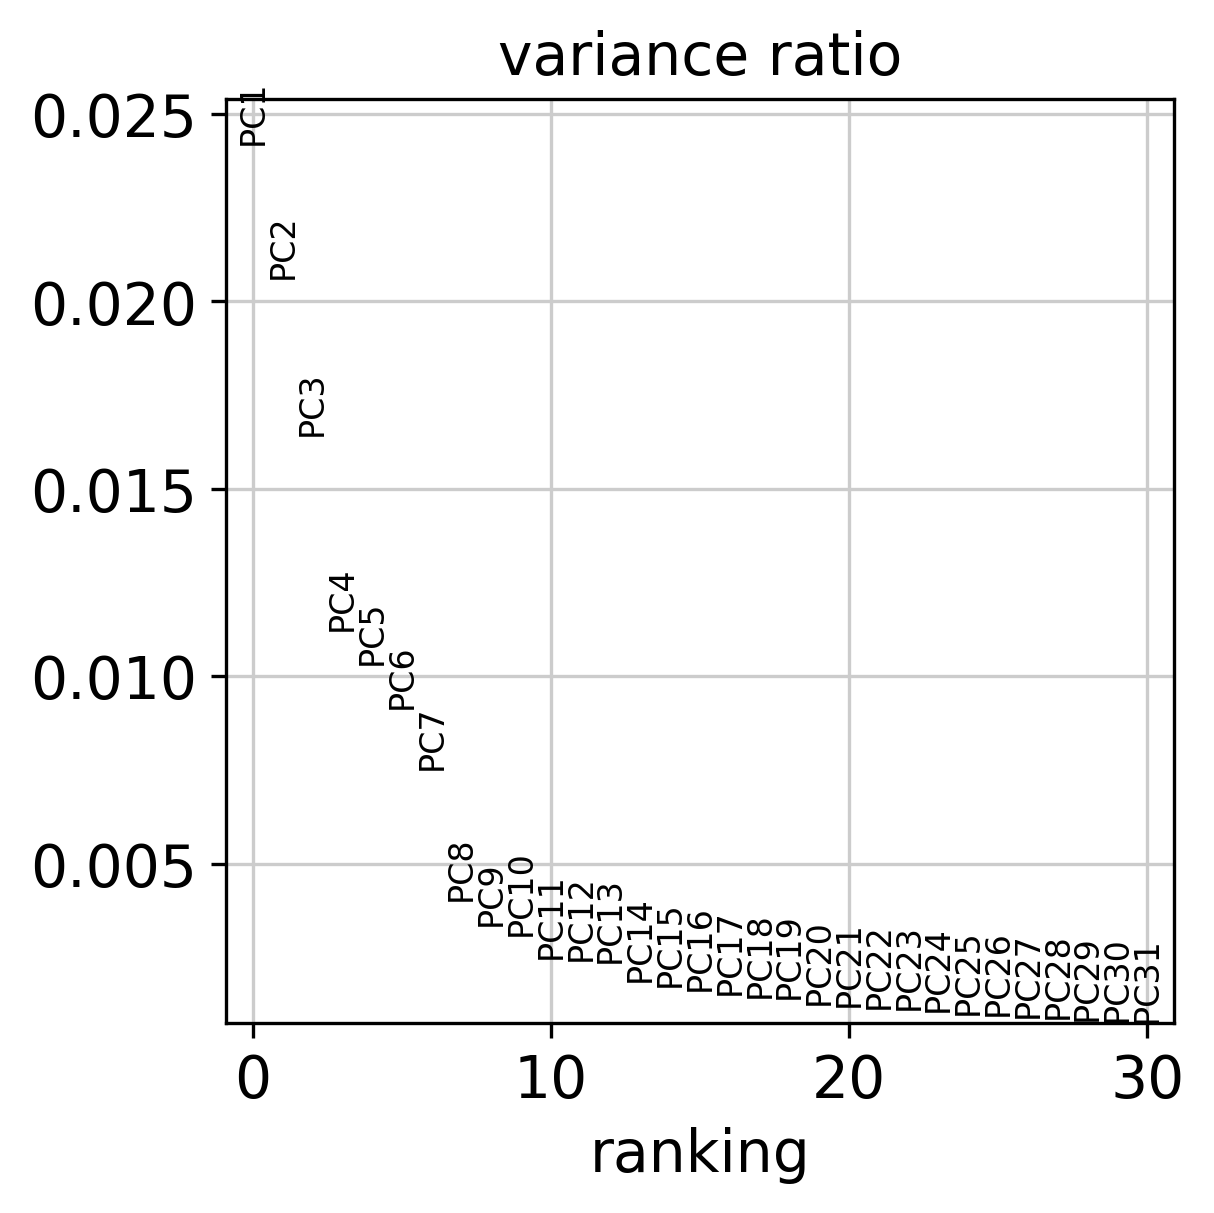

In [453]:
sc.pl.pca_variance_ratio(adata_conca, log=False)

In [454]:
pca_ndims = 17

In [455]:
sc.pp.neighbors(adata_conca, n_neighbors=10, n_pcs=pca_ndims)

computing neighbors
    using 'X_pca' with n_pcs = 17
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [456]:
sc.tl.umap(adata_conca)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


In [457]:
adata_conca.obsm['X_umap']

array([[11.830455  , -2.4637275 ],
       [14.43397   , -0.59707206],
       [ 7.7701507 , -6.7204704 ],
       ...,
       [-2.4140525 , -6.6610136 ],
       [-1.693557  , -5.8076124 ],
       [ 2.8934658 , -4.636676  ]], dtype=float32)

Text(0.5, 1.0, 'batch bf BBKNN')

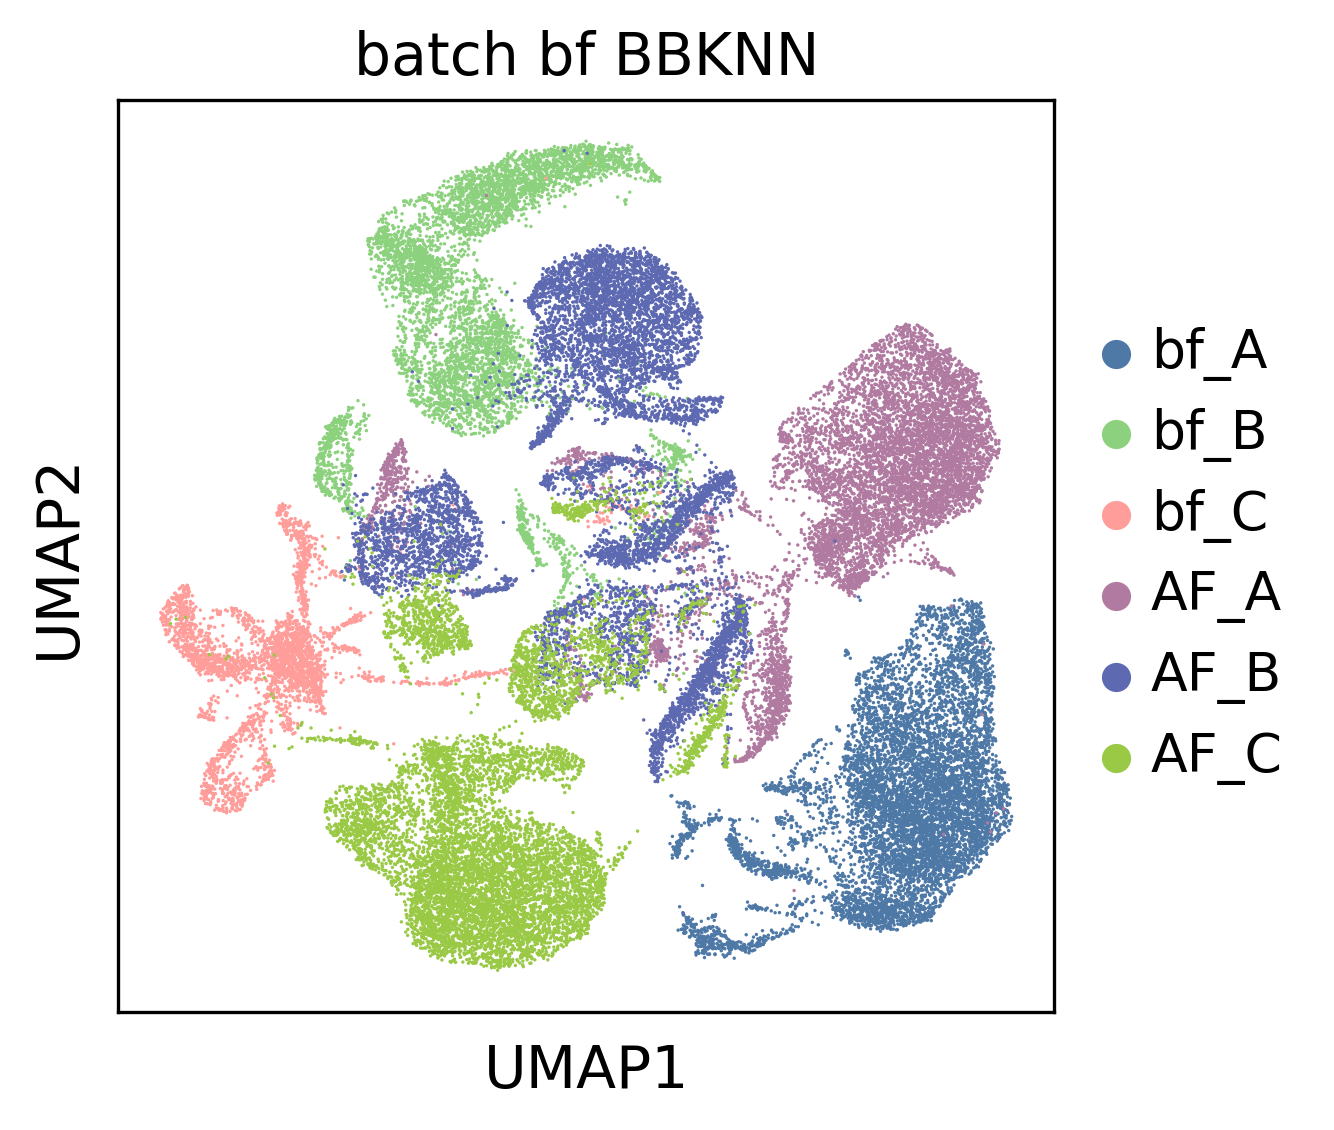

In [458]:
ax = sc.pl.umap(adata_conca, color = ['batch'], palette = ["#4E79A7", "#8CD17D", "#FF9D9A", "#B07AA1", "#5D69B1", '#99C945'], show = False)
ax.set_title(f'batch bf BBKNN')
# palette will be stored in uns

##  BBKNN

In [465]:
adata_BBKNN = adata_conca.copy()

CPU times: user 3.34 s, sys: 6.44 s, total: 9.78 s
Wall time: 9.79 s


In [466]:
%%time
sc.external.pp.bbknn(adata_BBKNN, batch_key='batch')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
CPU times: user 8.16 s, sys: 227 ms, total: 8.39 s
Wall time: 7.78 s


这一步只是更新了neighbors的数据，需要重新进行umap，并可以基于此neighbors数据进行后续聚类

In [467]:
sc.tl.umap(adata_BBKNN)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


Text(0.5, 1.0, 'batch AF BBKNN')

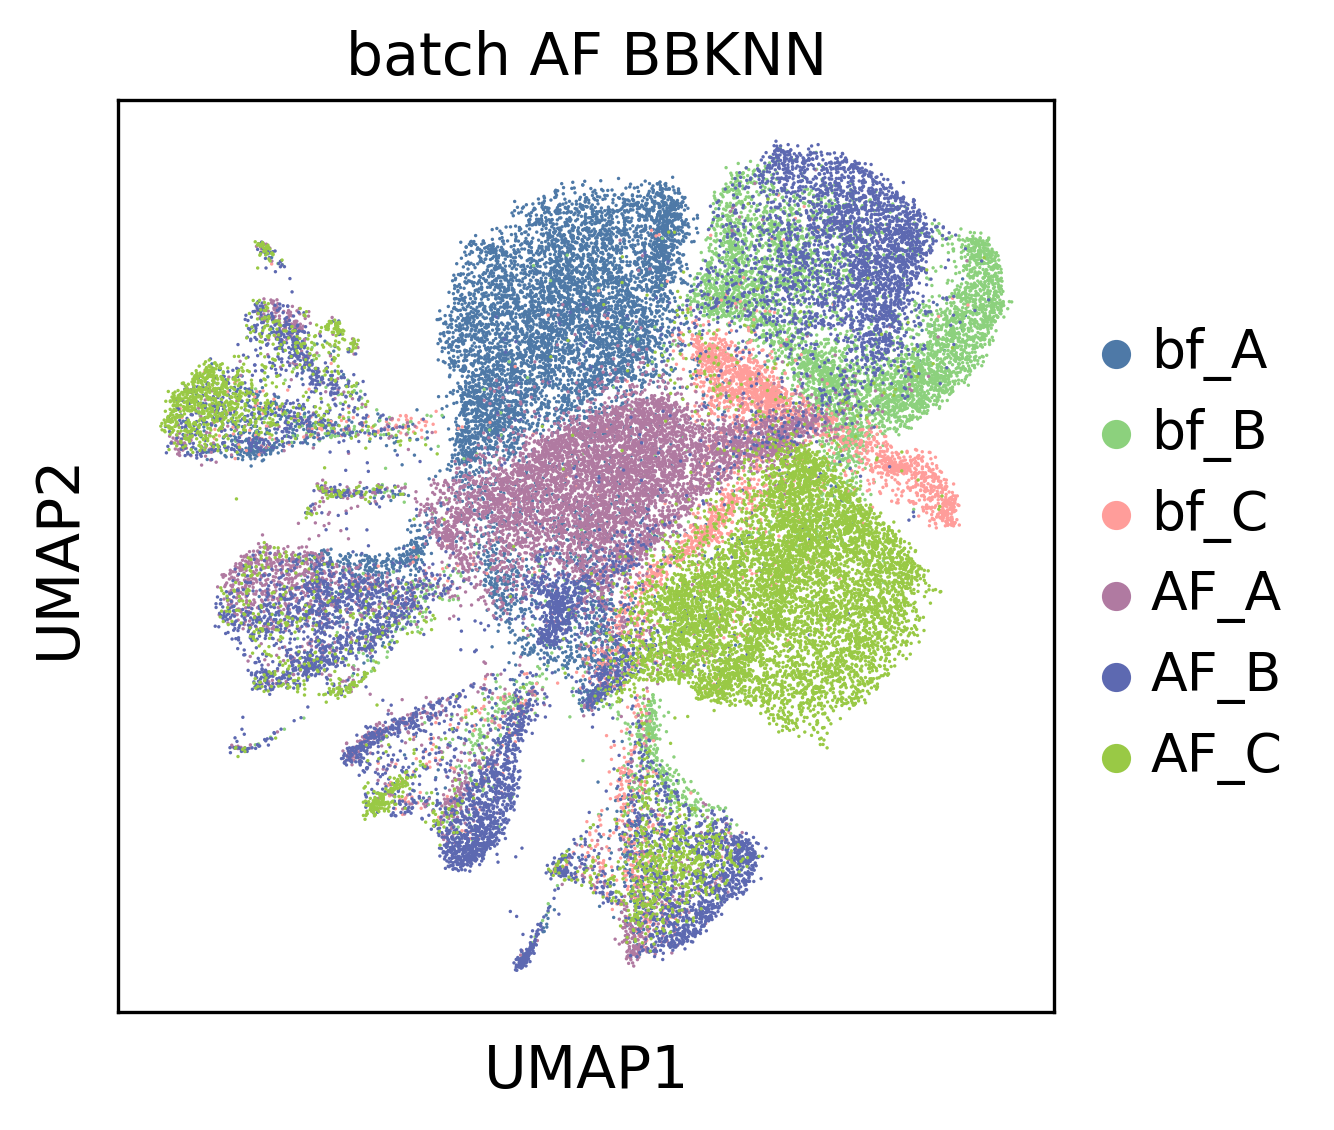

In [468]:
ax = sc.pl.umap(adata_BBKNN, color = ['batch'], show = False)
ax.set_title(f'batch AF BBKNN')

In [469]:
adata_BBKNN.write_h5ad('/home/data/t140408/B3_snSeq/ipython/results/adata_BBKNN.h5ad', compression='gzip')

## harmony 

In [470]:
adata_harmony = adata_conca.copy()

In [472]:
%%time
sc.external.pp.harmony_integrate(adata_harmony, key='batch')

2024-01-14 22:53:51,197 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-01-14 22:54:26,689 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-01-14 22:54:27,819 - harmonypy - INFO - Iteration 1 of 10
2024-01-14 22:54:50,298 - harmonypy - INFO - Iteration 2 of 10
2024-01-14 22:55:12,955 - harmonypy - INFO - Converged after 2 iterations


CPU times: user 52min 33s, sys: 1h 32min 25s, total: 2h 24min 59s
Wall time: 1min 21s


In [476]:
adata_harmony

AnnData object with n_obs × n_vars = 44781 × 5555
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids-AF_A', 'feature_types-AF_A', 'n_cells-AF_A', 'n_cells_by_counts-AF_A', 'mean_counts-AF_A', 'pct_dropout_by_counts-AF_A', 'total_counts-AF_A', 'gene_ids-AF_B', 'feature_types-AF_B', 'n_cells-AF_B', 'n_cells_by_counts-AF_B', 'mean_counts-AF_B', 'pct_dropout_by_counts-AF_B', 'total_counts-AF_B', 'gene_ids-AF_C', 'feature_types-AF_C', 'n_cells-AF_C', 'n_cells_by_counts-AF_C', 'mean_counts-AF_C', 'pct_dropout_by_counts-AF_C', 'total_counts-AF_C', 'gene_ids-bf_A', 'feature_types-bf_A', 'n_cells-bf_A', 'n_cells_by_counts-bf_A', 'mean_counts-bf_A', 'pct_dropout_by_counts-bf_A', 'total_counts-bf_A', 'gene_ids-bf_B', 'feature_types-bf_B', 'n_cells-bf_B', 'n_cells_by_counts-bf_B', 'mean_counts-bf_B', 'pct_dropout_by_counts-bf_B', 'total_counts-bf_B', 'gene_ids-bf_C', 'feature_types-bf_C', 'n_cells-bf_C', 'n_cells_by_counts-bf_C',

如果要画harmony后的elbow图，需要将X_pca_harmony复制给X_pca，此处用R的harmony做出的数值

In [475]:
harmony_ndims = 26

In [477]:
sc.pp.neighbors(adata_harmony, n_neighbors=10, n_pcs=harmony_ndims, use_rep='X_pca_harmony')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [478]:
sc.tl.umap(adata_harmony)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


Text(0.5, 1.0, 'batch AF harmony')

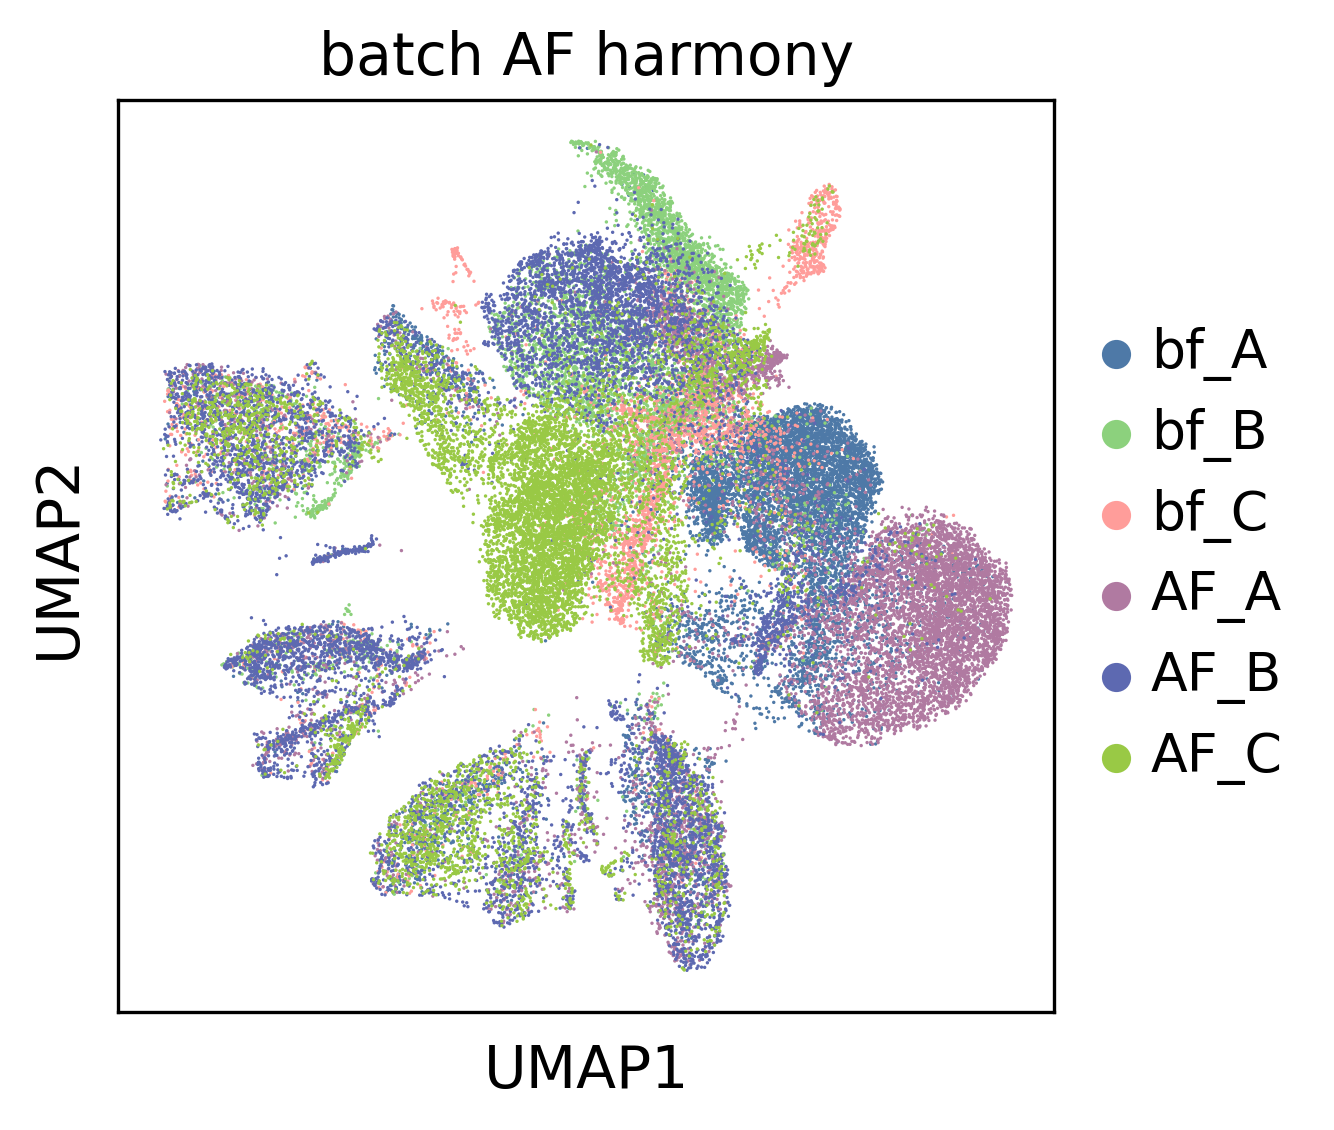

In [479]:
ax = sc.pl.umap(adata_harmony, color = ['batch'], palette = ["#4E79A7", "#8CD17D", "#FF9D9A", "#B07AA1", "#5D69B1", '#99C945'], show = False)
ax.set_title(f'batch AF harmony')
# palette will be stored in uns

harmony 相较于BBKNN 速度稍慢，而且还是容易出现过拟合

In [480]:
adata_harmony.write_h5ad('/home/data/t140408/B3_snSeq/ipython/results/adata_harmony.h5ad', compression='gzip')